In [1]:
import pandas as pd
import numpy as np
import pymssql
from sqlalchemy import create_engine, text

import plotly.express as px
import plotly.graph_objects as go
from scipy.spatial import ConvexHull

import platform
import json
import os
import sys
parent_path = os.path.abspath('..')
sys.path.append(parent_path)
parent_path = os.path.abspath('../../')
sys.path.append(parent_path)
parent_path = os.path.abspath('../../../')
sys.path.append(parent_path)
print(sys.path)

os_name = platform.system()
if os.name == 'nt' or os_name == 'Windows':
    DATA_PATH = r"D:/data/sisi/"
elif os.name == 'posix' or os_name == 'Linux':
    DATA_PATH = r"/mnt/d/data/sisi/"
else:
    DATA_PATH = r"/mnt/d/data/sisi/"

['C:\\Users\\qiu\\anaconda3\\envs\\SISI\\python38.zip', 'C:\\Users\\qiu\\anaconda3\\envs\\SISI\\DLLs', 'C:\\Users\\qiu\\anaconda3\\envs\\SISI\\lib', 'C:\\Users\\qiu\\anaconda3\\envs\\SISI', '', 'C:\\Users\\qiu\\anaconda3\\envs\\SISI\\lib\\site-packages', 'C:\\Users\\qiu\\anaconda3\\envs\\SISI\\lib\\site-packages\\win32', 'C:\\Users\\qiu\\anaconda3\\envs\\SISI\\lib\\site-packages\\win32\\lib', 'C:\\Users\\qiu\\anaconda3\\envs\\SISI\\lib\\site-packages\\Pythonwin', 'C:\\Users\\qiu\\IdeaProjects\\SISI\\core\\ShoreNet', 'C:\\Users\\qiu\\IdeaProjects\\SISI\\core', 'C:\\Users\\qiu\\IdeaProjects\\SISI']


In [2]:
# load dock polygon
# Define the connection details
server = '127.0.0.1'
user = 'sa'
password = 'Amacs%400212'
database = 'sisi'

ss_engine = create_engine(f'mssql+pymssql://{user}:{password}@{server}:1433/{database}')
query = f"""
SELECT 
    Id, Name, Polygon.STAsText() as Polygon, Province, lng, lat 
FROM 
    sisi.ShoreNet.tab_dock_polygon
WHERE
    type_id = 1 or type_id = 6
"""
dock_df = pd.read_sql(query, ss_engine)

import re
dock_polygon_list = []
for _, row in dock_df.iterrows():
    wkt_polygon = row['Polygon']
    pattern = re.compile(r'\d+\.\d+\s\d+\.\d+')
    matches = pattern.findall(wkt_polygon)
    coordinates = [[float(coord) for coord in match.split()] for match in matches]
    dock_polygon_list.append(
        {
            'dock_id': row['Id'], 'name': row['Name'], 'polygon': coordinates, 'province': row['Province'],
            'lng': row['lng'], 'lat': row['lat']
        }
    )
print('dock polygons loaded...', len(dock_polygon_list))

dock polygons loaded... 1519


# 1 Measure dock polygons

## 1.1 Cleaning:

1. Load whole events from SQL Server
2. Clean events with DBSCAN, parameter is {radius: 200m, cluster_min_count: 30}
3. Filter noise cluster
4. Futher filter: If there are less 20 ships and the count of events less than 60, the cluster will also be recognized as noise cluster.
5. After the double filter, we get the cleaned events dataframe.

In [3]:
# count all sail logging
count_all_coal_query = f"""
SELECT 
    mmsi, 
    Begin_time as begin_time, End_time as end_time, end_time - begin_time as duration, 
    lng, lat, Point_num as point_num, Event_categories, coal_dock_id
FROM 
    sisi.ShoreNet.tab_sailing_log t
WHERE
    t.avgSpeed < 1
    -- and Begin_time > 1680267600 and Begin_time < 1717164000
"""

coal_mmsi_file_name = r'C:\Users\qiu\IdeaProjects\SISI\core\ShoreNet\scripts\coal_mmsi_v1_init.json'
rf = open(coal_mmsi_file_name, 'r')
coal_mmsi_dict = json.load(rf)
print(coal_mmsi_dict['mmsi'][:5], len(coal_mmsi_dict['mmsi']))
coal_mmsi_list = [int(m) for m in coal_mmsi_dict['mmsi']]
rf.close()

all_coal_df = pd.read_sql(
    sql=text(count_all_coal_query), con=ss_engine
)
all_coal_df = all_coal_df.loc[(all_coal_df['duration'] > 1800) & 
                              (all_coal_df['duration'] < 7 * 86400) &
                              (all_coal_df['mmsi'].isin(coal_mmsi_list))]

with_polygon_coal_df = all_coal_df.loc[~all_coal_df['coal_dock_id'].isna()]

print("all coal dataframe shape: ", all_coal_df.shape)
print("with poygon coal dataframe shape: ", with_polygon_coal_df.shape)
print(f"all coal dataframe contains: {all_coal_df['mmsi'].nunique()} ships")
print(f"polygon coal dataframe contains: {with_polygon_coal_df['mmsi'].nunique()} ships")
print(f"Event with polygon percentage : {100 * with_polygon_coal_df.shape[0] / all_coal_df.shape[0]} %")


## dbscan
# dbscan all coal df, filter noise cluster, then check the percentage.
from sklearn.cluster import DBSCAN

# dbscan all_coal_df
coords = all_coal_df[['lng', 'lat']].values

kms_per_radian = 6371.0088
epsilon = 0.2 / kms_per_radian

# DBSCAN clustering
db = DBSCAN(eps=epsilon, min_samples=30, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))

# Add cluster labels to the DataFrame
all_coal_df['cluster'] = db.labels_

cluster_counts = all_coal_df['cluster'].value_counts()

print("cluster count describe: ")
print(cluster_counts.describe())

# calculate the percentage
all_coal_df = all_coal_df.loc[all_coal_df['cluster']!=-1]

[411041792, 3, 411041797, 229376006, 413794311] 35447
all coal dataframe shape:  (1613098, 9)
with poygon coal dataframe shape:  (879405, 9)
all coal dataframe contains: 34108 ships
polygon coal dataframe contains: 33153 ships
Event with polygon percentage : 54.51652658424969 %
cluster count describe: 
count      3154.000000
mean        511.445149
std        5126.865386
min           9.000000
25%          46.250000
50%          85.000000
75%         202.000000
max      206034.000000
Name: count, dtype: float64


## 1.2 Calculate the percentage of events in the polygon

In [4]:
cleaned_cluster_id_list = []
for cluster_id, group in all_coal_df.groupby('cluster'):
    # the condition of a events_cluster, must be:
    # 1. ship unique counts > 20
    # 2. group size > 2 * dbscan_radius
    if (group['mmsi'].nunique() > 200) & (group.shape[0] > 400):
        cleaned_cluster_id_list.append(cluster_id)
print(f"events cluster count : {len(cleaned_cluster_id_list)}")
cleaned_coal_df = all_coal_df.loc[all_coal_df['cluster'].isin(cleaned_cluster_id_list)]
with_polygon_dbscan_df = cleaned_coal_df.loc[~cleaned_coal_df['coal_dock_id'].isna()]
without_polygon_dbscan_df = cleaned_coal_df.loc[cleaned_coal_df['coal_dock_id'].isna()]
print(with_polygon_dbscan_df.shape, without_polygon_dbscan_df.shape, cleaned_coal_df.shape)
print(f"Event with polygon percentage is {100 * with_polygon_dbscan_df.shape[0] / cleaned_coal_df.shape[0]} %")

events cluster count : 215
(707695, 10) (242333, 10) (950028, 10)
Event with polygon percentage is 74.49201497219029 %


## 1.3 plot the events without polygon on map

In [6]:
# plot without polygon events
def generate_plot_hull(df, cluster_name):
    plot_row_list = []
    hull_df_list = []
    for coal_dock_id, group in df.groupby(cluster_name):
        _row = group.iloc[0, :]
        # print(_row)
        _d = {'cluster': _row[cluster_name], 'lng': _row['lng'], 'lat': _row['lat'], 'size': group.shape[0]}
        plot_row_list.append(_d)
    
        # get hull data
        num_rows = group.shape[0]
        num_select = int(num_rows * 1.0)
    
        # Randomly select row indices
        selected_indices = np.random.choice(num_rows, num_select, replace=False)
        hull_df_list.append(group.iloc[selected_indices, :])
    plot_df = pd.DataFrame(plot_row_list)
    hull_df = pd.concat(hull_df_list, ignore_index=True)
    hull_df.loc[:, 'mmsi'] = hull_df['mmsi'].astype(str)
    return plot_df, hull_df


def plot_on_map(plot_df, hull_df, cluster_name):
    import plotly.express as px
    import plotly.graph_objects as go
    from scipy.spatial import ConvexHull

    fig = go.Figure()

    # Create a scatter mapbox plot with clusters
    fig = px.scatter_mapbox(
        plot_df,
        lat="lat",
        lon="lng",
        color=cluster_name,
        size="size",
        hover_name=cluster_name,
        hover_data={"size": True, "lat": True, "lng": True},
        title="Clusters on Map",
        color_continuous_scale=px.colors.cyclical.IceFire,
        zoom=5,
        height=600
    )
    
    # Calculate and add the convex hull for each cluster
    unique_clusters = hull_df[cluster_name].unique()
    
    for cluster in unique_clusters:
        if cluster == -1:  # Skip noise points
            continue
        cluster_points = hull_df[hull_df[cluster_name] == cluster][['lng', 'lat']].values
    
        if len(cluster_points) > 2:  # Convex hull requires at least 3 points
            try:
                hull = ConvexHull(cluster_points)
                hull_points = np.append(hull.vertices, hull.vertices[0])  # Append the first point to close the hull
                fig.add_trace(go.Scattermapbox(
                    lon=cluster_points[hull_points, 0],
                    lat=cluster_points[hull_points, 1],
                    mode='lines',
                    fill='toself',
                    fillcolor='rgba(0, 0, 255, 0.1)',  # Semi-transparent fill color
                    line=dict(color='blue'),
                    name=f'Cluster {cluster} Hull'
                ))
            except:
                print(f"cluster_id : {cluster} hull failed.")
    
    # Set the map style and layout
    fig.update_layout(
        mapbox_style="carto-positron",
        mapbox_center={"lat": plot_df["lat"].mean(), "lon": plot_df["lng"].mean()},
        margin={"r":0,"t":0,"l":0,"b":0},
        height=700, width=1200
    )
    
    fig.write_html(r'C:\Users\qiu\IdeaProjects\SISI\core\ShoreNet\notebooks\html\new_tmp.html')
    # fig.show()

plot_df, hull_df = generate_plot_hull(without_polygon_dbscan_df, 'cluster')
print(plot_df.shape, hull_df.shape)
# print(plot_df.describe())

tmp_plot_df = plot_df.loc[plot_df['size'] > 1500]
tmp_hull_df = hull_df.loc[hull_df['cluster'].isin(tmp_plot_df['cluster'])]
print(tmp_plot_df.head())
print(tmp_plot_df.shape, tmp_hull_df.shape)
print(tmp_plot_df.describe())

plot_on_map(tmp_plot_df, tmp_hull_df, 'cluster')

(211, 4) (242330, 10)
   cluster         lng        lat   size
0        0  108.316467  21.614716  15464
3        5  118.013763  38.924267   3231
4        9  122.200119  29.947166   2254
5       10  121.723198  29.960482   4958
8       16  120.239563  36.028030   3400
(41, 4) (136514, 10)
          cluster         lng        lat          size
count   41.000000   41.000000  41.000000     41.000000
mean   169.902439  119.158306  30.707983   3329.609756
std    186.428915    3.653639   3.593480   2475.587464
min      0.000000  108.316467  21.614716   1520.000000
25%     50.000000  118.863243  29.963289   1769.000000
50%    117.000000  120.371597  31.702299   2760.000000
75%    226.000000  121.259743  32.036201   3691.000000
max    761.000000  122.249130  38.924267  15464.000000


# 2 Statistics

## 2.1 Cargo List

In [11]:
coal_event_df = with_polygon_dbscan_df.copy()
coal_event_df.sort_values('begin_time', inplace=True)
coal_event_gdf = coal_event_df.groupby('mmsi')
for mmsi, group in coal_event_gdf:
    if group['coal_dock_id'].nunique() > 1:
        print(f"{mmsi}, {group['coal_dock_id'].unique()}")

coal_event_df.describe()

3, [ 136. 6018.]
10, [4601. 6044.]
26, [4592.  136.]
29, [4592.  136.]
30, [4591.  135.]
31, [135. 136.]
33, [4592.  135.]
37, [ 135. 4592.]
40, [ 136. 4592.]
41, [ 136. 4592. 5724.]
44, [ 136. 4592.]
47, [6021. 4592.]
52, [6044.  135. 4592.]
53, [4592.  136.]
57, [4592.  135.]
60, [4592.  136.  135.  137. 4603. 6044. 5271.]
61, [4592.  135.  136. 6044.]
62, [4592.  135.  136. 6021.]
63, [4592.  136.  135.]
120, [5275.   49.]
20168, [5819.   19.]
55941, [4767.  137.]
413872, [ 198. 4813.]
620841, [ 116. 5618.]
4131407, [6023.   25.  116.]
4131419, [4594. 6023.  116.   25.]
8212811, [4666. 4668.   46.]
10122129, [4666.   46.]
10123410, [4668.   46.]
10123413, [4666. 4668.   46.]
10188003, [4598.  171.]
10672002, [5618.  116.]
11362001, [5618.  116.]
11362002, [5618.  116.]
11362003, [5618.  116.]
11362004, [5618.  116.]
11362005, [5618.  116.]
11362006, [5618.  116.]
11362007, [5618.  116.]
11362008, [5618.  116.]
11362009, [5618.  116.]
11362010, [5618.  116.]
13141902, [5618.  116.]
1

mmsi    begin_time      end_time       duration            lng  \
count  7.076950e+05  7.076950e+05  7.076950e+05  707695.000000  707695.000000   
mean   4.236159e+08  1.689201e+09  1.689255e+09   54000.603948     119.337701   
std    7.553914e+07  9.020501e+06  9.021153e+06   78683.703790       3.192639   
min    3.000000e+00  1.672531e+09  1.672533e+09    1801.000000     108.314178   
25%    4.132266e+08  1.681329e+09  1.681362e+09    9305.000000     117.867531   
50%    4.135001e+08  1.689294e+09  1.689345e+09   26989.000000     120.223717   
75%    4.138427e+08  1.697086e+09  1.697148e+09   65577.000000     121.642197   
max    1.048382e+09  1.704065e+09  1.704067e+09  604749.000000     122.462158   

                 lat      point_num   coal_dock_id        cluster  
count  707695.000000  707695.000000  707695.000000  707695.000000  
mean       32.275106     104.323012    4033.995148     119.100143  
std         4.317216     454.733896    2366.934830     188.147861  
min        21.495131       1.000000      10.000000       7.000000  
25%        29.934265       5.000000     202.000000      10.000000  
50%        31.759066      16.000000    4825.000000      35.000000  
75%        34.803972      61.000000    6018.000000     155.000000  
max        39.939381   49132.000000    6044.000000    1535.000000

In [5]:
## dbscan without_polygon_dbscan_df
from sklearn.cluster import DBSCAN

from core.ShoreNet.utils.hull_polygon import hull_points_to_sql


coords = without_polygon_dbscan_df[['lng', 'lat']].values

kms_per_radian = 6371.0088
epsilon = 0.2 / kms_per_radian

# DBSCAN clustering
db = DBSCAN(eps=epsilon, min_samples=30, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))

# Add cluster labels to the DataFrame
without_polygon_dbscan_df['cluster'] = db.labels_

cluster_counts = without_polygon_dbscan_df['cluster'].value_counts()

print("cluster count describe: ")
print(cluster_counts.describe())

c_dict_list = []
for cluster_id, group in without_polygon_dbscan_df.groupby('cluster'):
    first_row = group.iloc[0, :]
    if (group.shape[0] > 100) & (group['mmsi'].nunique() > 30):
        c_dict = {'cluster': cluster_id, 'size': group.shape[0], 'lng': first_row['lng'], 'lat': first_row['lat']}
        c_dict_list.append(c_dict)
without_polgon_dbscan_merged_df = pd.DataFrame(c_dict_list)
without_polgon_dbscan_merged_df.describe()

cluster count describe: 
count      240.000000
mean       583.983333
std       2695.126572
min         30.000000
25%         61.750000
50%        106.000000
75%        204.500000
max      28469.000000
Name: count, dtype: float64


C:\Users\qiu\AppData\Local\Temp\ipykernel_32748\1505934784.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  without_polygon_dbscan_df['cluster'] = db.labels_


cluster          size         lng        lat
count   89.000000     89.000000   89.000000  89.000000
mean    75.393258   1411.415730  120.573865  33.440982
std     55.395811   4314.630203    1.779665   3.851279
min     -1.000000    101.000000  113.849403  29.722116
25%     29.000000    148.000000  119.486145  29.961599
50%     60.000000    219.000000  121.479668  31.197100
75%    120.000000    550.000000  122.024452  36.109314
max    208.000000  28469.000000  122.268967  40.747780

In [6]:
hull_points_to_sql(without_polygon_dbscan_df)
print(f"hull save sql server successfully.")

hull save sql server successfully.


In [5]:
all_coal_df.describe()

mmsi    begin_time      end_time       duration            lng  \
count  2.050780e+05  2.050780e+05  2.050780e+05  205078.000000  205078.000000   
mean   4.203878e+08  1.689212e+09  1.689272e+09   60797.299076     120.267417   
std    7.132258e+07  9.052542e+06  9.055160e+06   85170.036808       1.848635   
min    1.000001e+08  1.672531e+09  1.672533e+09    1801.000000     106.436119   
25%    4.123620e+08  1.681458e+09  1.681550e+09   12980.250000     117.945505   
50%    4.132730e+08  1.689153e+09  1.689222e+09   35504.500000     120.324699   
75%    4.134368e+08  1.697011e+09  1.697082e+09   69397.000000     121.929680   
max    9.999338e+08  1.704062e+09  1.704067e+09  604742.000000     125.151146   

                 lat      point_num   coal_dock_id        cluster  
count  205078.000000  205078.000000  184251.000000  205078.000000  
mean       34.007251     121.733804    1035.272590      60.382084  
std         4.116027     551.086515     543.340794      98.125990  
min        18.053049       1.000000       3.000000       0.000000  
25%        29.935717       5.000000    1297.000000       8.000000  
50%        35.325661      14.000000    1298.000000      13.000000  
75%        38.952881      40.000000    1317.000000      63.000000  
max        40.749664   49132.000000    1531.000000     498.000000

In [9]:
all_coal_df.loc[all_coal_df['lat'] < 29].shape, all_coal_df.loc[all_coal_df['lat'] > 29].shape

((1601, 10), (203477, 10))

# Check South China stopping events

In [3]:
# check south china event logs
import os
import platform

start_month, end_month = 1, 12
months = [f"2023{x:02}" for x in range(start_month, end_month+1)]
use_fields = [
                 'mmsi', 'Begin_time', 'End_time', 'Begin_lon', 'Begin_lat',
                 'avgSpeed', 'Point_num', 'nowPortName', 'nowDockName', 'nowBerthName', 'Event_categories'
             ]

month_sail_df_list = []
for month in months:
    month_sail_df = pd.read_csv(f"{DATA_PATH}/log_data/{month}_new_sailingv4.csv",
                                skipinitialspace=True, usecols=use_fields)
    month_sail_df.rename(columns={'Begin_lon': 'lng', 'Begin_lat': 'lat'}, inplace=True)
    month_sail_df.loc[:, 'lng'] = month_sail_df['lng'].multiply(0.000001)
    month_sail_df.loc[:, 'lat'] = month_sail_df['lat'].multiply(0.000001)

    month_sail_df = month_sail_df.loc[(month_sail_df['lng'] > 105.5) & (month_sail_df['lng'] < 126) &
                                      (month_sail_df['lat'] > 18) & (month_sail_df['lat'] < 29.7) &  # south china lat
                                      (month_sail_df['avgSpeed'] < 1)]
    month_sail_df_list.append(month_sail_df)
    
sail_df = pd.concat(month_sail_df_list, ignore_index=True)
sail_df

C:\Users\qiu\AppData\Local\Temp\ipykernel_55176\3302991077.py:22: DtypeWarning: Columns (34,36) have mixed types. Specify dtype option on import or set low_memory=False.
  month_sail_df = pd.read_csv(f"{DATA_PATH}/log_data/{month}_new_sailingv4.csv",
C:\Users\qiu\AppData\Local\Temp\ipykernel_55176\3302991077.py:22: DtypeWarning: Columns (34,36) have mixed types. Specify dtype option on import or set low_memory=False.
  month_sail_df = pd.read_csv(f"{DATA_PATH}/log_data/{month}_new_sailingv4.csv",
C:\Users\qiu\AppData\Local\Temp\ipykernel_55176\3302991077.py:22: DtypeWarning: Columns (34,36) have mixed types. Specify dtype option on import or set low_memory=False.
  month_sail_df = pd.read_csv(f"{DATA_PATH}/log_data/{month}_new_sailingv4.csv",
C:\Users\qiu\AppData\Local\Temp\ipykernel_55176\3302991077.py:22: DtypeWarning: Columns (34,36) have mixed types. Specify dtype option on import or set low_memory=False.
  month_sail_df = pd.read_csv(f"{DATA_PATH}/log_data/{month}_new_sailingv4.cs

mmsi    Begin_time      End_time         lng        lat  \
0        0.000000e+00  1.674779e+09  1.674785e+09  121.919650  29.004600   
1        0.000000e+00  1.674864e+09  1.674930e+09  121.883800  29.162200   
2        1.000000e+00  1.672964e+09  1.672964e+09  119.778831  26.293931   
3        1.000000e+00  1.673741e+09  1.675181e+09  120.283991  22.627266   
4        2.000000e+00  1.673054e+09  1.673074e+09  108.697981  18.682066   
...               ...           ...           ...         ...        ...   
6887765  9.999990e+08  1.701389e+09  1.702944e+09  118.000999  24.429199   
6887766  9.999990e+08  1.703030e+09  1.704067e+09  118.000999  24.429199   
6887767  1.028074e+09  1.703757e+09  1.703769e+09  118.119202  24.321301   
6887768  1.059699e+09  1.701659e+09  1.701670e+09  118.116203  24.324699   
6887769  1.067304e+09  1.703985e+09  1.703987e+09  118.099503  24.358699   

         Point_num  avgSpeed    nowPortName                 nowDockName  \
0              8.0       0.0      shipuanch                          -1   
1            219.0       0.0          shipu           Dongxing Peroleum   
2              2.0       0.0  lianjianganch                          -1   
3            693.0       0.0      kaohsiung  Penglai Commercial Harbour   
4              3.0       0.0            NaN                         NaN   
...            ...       ...            ...                         ...   
6887765      126.0       0.0         xiamen                          -1   
6887766      258.0       0.0         xiamen                          -1   
6887767       14.0       0.0         xiamen                          -1   
6887768       14.0       0.0         xiamen                          -1   
6887769       16.0       0.0         xiamen                          -1   

        nowBerthName Event_categories  
0                 -1  low_speed_event  
1                 -1  low_speed_event  
2                 -1  low_speed_event  
3                 -1  low_speed_event  
4                NaN  low_speed_event  
...              ...              ...  
6887765           -1      record_poly  
6887766           -1      record_poly  
6887767           -1      record_poly  
6887768           -1      record_poly  
6887769           -1      record_poly  

[6887770 rows x 11 columns]

In [5]:
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)


def find_dock(event_row, dock_list):
    """
    calculate the distance between the first point of the event and the first point of the dock polygon.
    """
    from core.ShoreNet.utils.geo import point_poly, get_geodist
    
    # dock_list = get_dock_list()
    # if np.random.randint(0, 100, 1)[0] < 5:
    #     print(f"{month}, {event_row['mmsi']}")

    for polygon in dock_list:
        dst_list = []
        for d_lng, d_lat in polygon['polygon']:
            geodist = get_geodist(event_row['lng'], event_row['lat'], d_lng, d_lat)
            dst_list.append(geodist)
            
        if min(dst_list) < 8:
            if point_poly(event_row['lng'], event_row['lat'], polygon['polygon']):
                return polygon['dock_id']

dock_tag = sail_df.parallel_apply(find_dock, args=(dock_polygon_list, ), axis=1)
sail_df.loc[:, 'coal_dock_id'] = dock_tag

sail_df

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


mmsi    Begin_time      End_time         lng        lat  \
0        0.000000e+00  1.674779e+09  1.674785e+09  121.919650  29.004600   
1        0.000000e+00  1.674864e+09  1.674930e+09  121.883800  29.162200   
2        1.000000e+00  1.672964e+09  1.672964e+09  119.778831  26.293931   
3        1.000000e+00  1.673741e+09  1.675181e+09  120.283991  22.627266   
4        2.000000e+00  1.673054e+09  1.673074e+09  108.697981  18.682066   
...               ...           ...           ...         ...        ...   
6887765  9.999990e+08  1.701389e+09  1.702944e+09  118.000999  24.429199   
6887766  9.999990e+08  1.703030e+09  1.704067e+09  118.000999  24.429199   
6887767  1.028074e+09  1.703757e+09  1.703769e+09  118.119202  24.321301   
6887768  1.059699e+09  1.701659e+09  1.701670e+09  118.116203  24.324699   
6887769  1.067304e+09  1.703985e+09  1.703987e+09  118.099503  24.358699   

         Point_num  avgSpeed    nowPortName                 nowDockName  \
0              8.0       0.0      shipuanch                          -1   
1            219.0       0.0          shipu           Dongxing Peroleum   
2              2.0       0.0  lianjianganch                          -1   
3            693.0       0.0      kaohsiung  Penglai Commercial Harbour   
4              3.0       0.0            NaN                         NaN   
...            ...       ...            ...                         ...   
6887765      126.0       0.0         xiamen                          -1   
6887766      258.0       0.0         xiamen                          -1   
6887767       14.0       0.0         xiamen                          -1   
6887768       14.0       0.0         xiamen                          -1   
6887769       16.0       0.0         xiamen                          -1   

        nowBerthName Event_categories  coal_dock_id  
0                 -1  low_speed_event           NaN  
1                 -1  low_speed_event           NaN  
2                 -1  low_speed_event           NaN  
3                 -1  low_speed_event           NaN  
4                NaN  low_speed_event           NaN  
...              ...              ...           ...  
6887765           -1      record_poly           NaN  
6887766           -1      record_poly           NaN  
6887767           -1      record_poly           NaN  
6887768           -1      record_poly           NaN  
6887769           -1      record_poly           NaN  

[6887770 rows x 12 columns]

In [7]:
sail_df.to_csv(os.path.join(DATA_PATH, "log_data/2023_sail_events_south_china_with_polygon.csv"), index=False)

In [12]:
sail_df = pd.read_csv(os.path.join(DATA_PATH, "log_data/2023_sail_events_south_china_with_polygon.csv"))
south_china_with_polygon_sail_df = sail_df.loc[~sail_df['coal_dock_id'].isna()]
print(south_china_with_polygon_sail_df.shape)

plot_row_list = []
hull_df_list = []
for coal_dock_id, group in south_china_with_polygon_sail_df.groupby('coal_dock_id'):
    _row = group.iloc[0, :]
    _d = {'coal_dock_id': coal_dock_id, 'lng': _row['lng'], 'lat': _row['lat'], 'size': group.shape[0]}
    plot_row_list.append(_d)

    # get hull data
    num_rows = group.shape[0]
    num_select = int(num_rows * 1.0)

    # Randomly select row indices
    selected_indices = np.random.choice(num_rows, num_select, replace=False)
    hull_df_list.append(group.iloc[selected_indices, :])
    
plot_df = pd.DataFrame(plot_row_list)
hull_df = pd.concat(hull_df_list, ignore_index=True)
hull_df.loc[:, 'mmsi'] = hull_df['mmsi'].astype(str)
print(plot_df.shape, hull_df.shape)
print(plot_df.describe())

C:\Users\qiu\AppData\Local\Temp\ipykernel_55000\2875881167.py:1: DtypeWarning:

Columns (8,9) have mixed types. Specify dtype option on import or set low_memory=False.



(66040, 12)
(60, 4) (66040, 12)
       coal_dock_id         lng        lat          size
count     60.000000   60.000000  60.000000     60.000000
mean     431.316667  115.728829  24.108670   1100.666667
std      549.204648    4.541632   2.854695   2295.521813
min       33.000000  108.327057  18.233200     22.000000
25%      137.750000  112.645422  21.815136    116.500000
50%      173.000000  115.624417  23.120199    356.000000
75%      191.250000  119.600603  25.576669   1068.750000
max     1530.000000  121.961681  29.223400  15140.000000


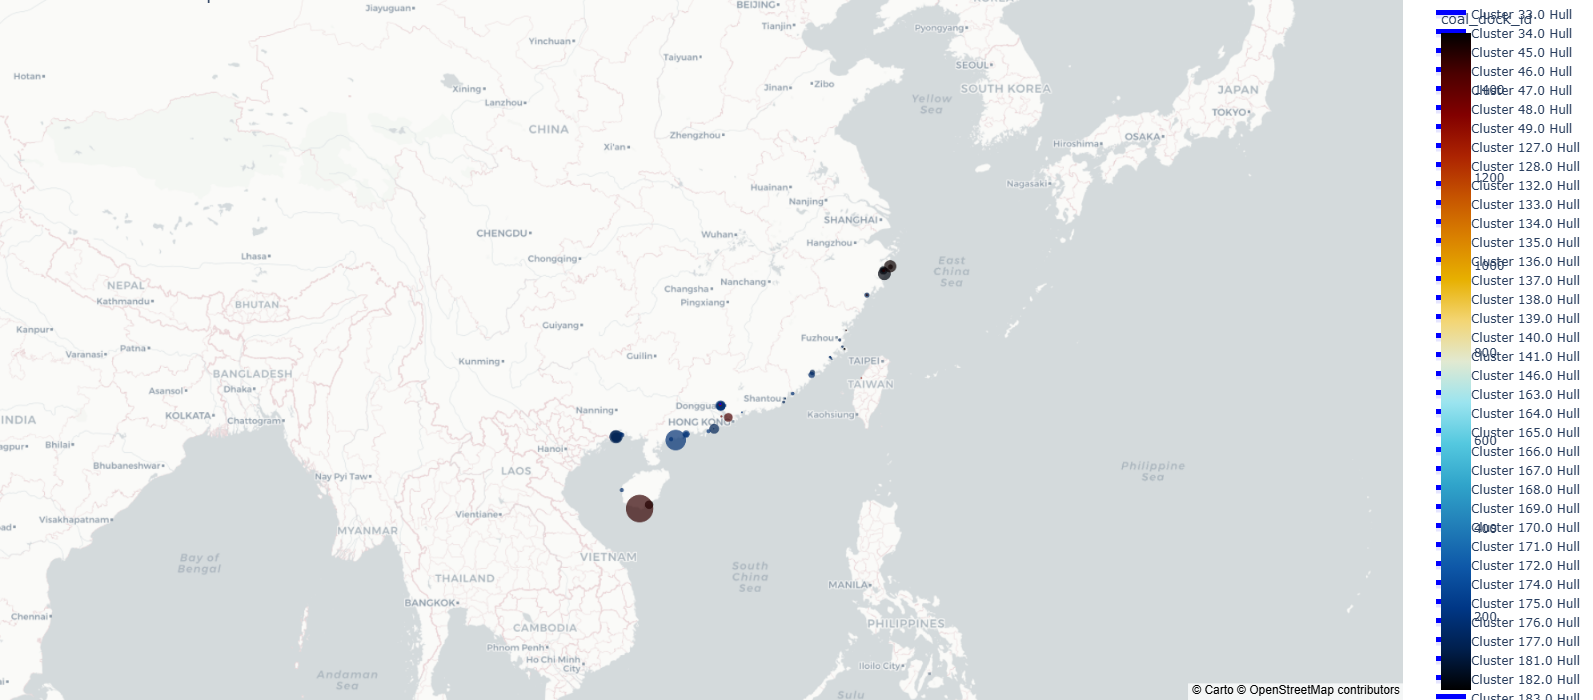

In [14]:


def plot_on_map(plot_df, hull_df, cluster_name):
    import plotly.express as px
    import plotly.graph_objects as go
    from scipy.spatial import ConvexHull
    
    mapbox_access_token = 'pk.eyJ1IjoibWFjc3FpdSIsImEiOiJjbHgxOGdybWQwOTNsMmpxNnR3Y3VpdTdyIn0.FusEYZ-4AUyJfOFVmjQAsw'

    fig = go.Figure()

    # Create a scatter mapbox plot with clusters
    fig = px.scatter_mapbox(
        plot_df,
        lat="lat",
        lon="lng",
        color=cluster_name,
        size="size",
        hover_name=cluster_name,
        hover_data={"size": True, "lat": True, "lng": True},
        title="Clusters on Map",
        color_continuous_scale=px.colors.cyclical.IceFire,
        zoom=5,
        height=600
    )
    
    # Calculate and add the convex hull for each cluster
    unique_clusters = hull_df[cluster_name].unique()
    
    for cluster in unique_clusters:
        if cluster == -1:  # Skip noise points
            continue
        cluster_points = hull_df[hull_df[cluster_name] == cluster][['lng', 'lat']].values
    
        if len(cluster_points) > 2:  # Convex hull requires at least 3 points
            try:
                hull = ConvexHull(cluster_points)
                hull_points = np.append(hull.vertices, hull.vertices[0])  # Append the first point to close the hull
                fig.add_trace(go.Scattermapbox(
                    lon=cluster_points[hull_points, 0],
                    lat=cluster_points[hull_points, 1],
                    mode='lines',
                    fill='toself',
                    fillcolor='rgba(0, 0, 255, 0.1)',  # Semi-transparent fill color
                    line=dict(color='blue'),
                    name=f'Cluster {cluster} Hull'
                ))
            except:
                print(f"cluster_id : {cluster} hull failed.")
    
    # Set the map style and layout
    fig.update_layout(
        mapbox_style="carto-positron",
        mapbox_center={"lat": plot_df["lat"].mean(), "lon": plot_df["lng"].mean()},
        margin={"r":0,"t":0,"l":0,"b":0},
        height=700, width=1200
    )
    
    # fig.write_html(r'C:\Users\qiu\IdeaProjects\SISI\core\ShoreNet\notebooks\html\new.html')
    fig.show()


plot_on_map(plot_df, hull_df, 'coal_dock_id')

In [25]:
coal_mmsi_file_name = 'coal_mmsi.json'
rf = open(coal_mmsi_file_name, 'r')
coal_mmsi_dict = json.load(rf)
print(coal_mmsi_dict['mmsi'][:5], len(coal_mmsi_dict['mmsi']))
coal_mmsi_list = [int(m) for m in coal_mmsi_dict['mmsi']]
rf.close()

print(len(coal_mmsi_list))

for mmsi, group in south_china_with_polygon_sail_df.groupby('mmsi'):
    if not mmsi in coal_mmsi_list:
        print(int(mmsi), coal_mmsi_list[:5])

[696254464, 412352514.0, 411041794, 412352516.0, 229376006] 30141
30141
3 [696254464, 412352514, 411041794, 412352516, 229376006]
7 [696254464, 412352514, 411041794, 412352516, 229376006]
8 [696254464, 412352514, 411041794, 412352516, 229376006]
10 [696254464, 412352514, 411041794, 412352516, 229376006]
13 [696254464, 412352514, 411041794, 412352516, 229376006]
20 [696254464, 412352514, 411041794, 412352516, 229376006]
22 [696254464, 412352514, 411041794, 412352516, 229376006]
23 [696254464, 412352514, 411041794, 412352516, 229376006]
24 [696254464, 412352514, 411041794, 412352516, 229376006]
25 [696254464, 412352514, 411041794, 412352516, 229376006]
26 [696254464, 412352514, 411041794, 412352516, 229376006]
27 [696254464, 412352514, 411041794, 412352516, 229376006]
28 [696254464, 412352514, 411041794, 412352516, 229376006]
29 [696254464, 412352514, 411041794, 412352516, 229376006]
30 [696254464, 412352514, 411041794, 412352516, 229376006]
31 [696254464, 412352514, 411041794, 412352516

In [5]:
plot_row_list = []
hull_df_list = []
all_coal_gdf = all_coal_df.groupby('cluster')
print(len(all_coal_gdf))
for cluster_id, group in all_coal_gdf:
    first_row = group.iloc[0, :]
    if (group.shape[0] > 100) & (group['mmsi'].nunique() > 30):
        # get points data
        c_dict = {'cluster': cluster_id, 'size': group.shape[0], 'lng': first_row['lng'], 'lat': first_row['lat']}
        plot_row_list.append(c_dict)

        # get hull data
        num_rows = group.shape[0]
        num_select = int(num_rows * 1.0)
    
        # Randomly select row indices
        selected_indices = np.random.choice(num_rows, num_select, replace=False)
        hull_df_list.append(group.iloc[selected_indices, :])
        
plot_df = pd.DataFrame(plot_row_list)
print(plot_df.shape)
print(plot_df.head())

hull_df = pd.concat(hull_df_list, ignore_index=True)
hull_df.loc[:, 'mmsi'] = hull_df['mmsi'].astype(str)
print(hull_df.shape)
print(hull_df.head())

300
(116, 4)
   cluster  size         lng        lat
0        0  3707  120.199165  35.995968
1        1  5341  120.311966  36.087265
2        2   435  120.244102  36.028580
3        3   257  120.238731  36.018417
4        4  9480  121.719902  29.952801
(168133, 10)
        mmsi  begin_time    end_time  duration         lng        lat  \
0  412436363  1700473727  1700476232      2505  120.222466  36.013248   
1  477308116  1701430443  1701433673      3230  120.220047  36.010864   
2  413330654  1689135773  1689144081      8308  120.195419  35.994865   
3  232024771  1680307316  1680374639     67323  120.229202  36.010601   
4  413289040  1677628816  1677652016     23200  120.189064  36.002132   

   point_num Event_categories  coal_dock_id  cluster  
0          5      record_poly          20.0        0  
1         11      record_poly          20.0        0  
2          9      record_poly        1311.0        0  
3        775  stop_event_poly          20.0        0  
4        137  low_sp

In [6]:
plot_df.describe()

cluster          size         lng         lat
count  116.000000    116.000000  116.000000  116.000000
mean    98.870690   1449.422414  120.384763   34.159161
std     69.703912   4839.544422    1.682654    3.847782
min      0.000000    101.000000  113.848076   29.723101
25%     39.750000    155.000000  119.436077   29.986188
50%     89.500000    271.500000  120.290058   35.272696
75%    149.250000    703.750000  121.989561   38.316619
max    289.000000  37762.000000  122.479950   40.748798

In [7]:
import plotly.express as px
import plotly.graph_objects as go
from scipy.spatial import ConvexHull
import numpy as np

mapbox_access_token = 'pk.eyJ1IjoibWFjc3FpdSIsImEiOiJjbHgxOGdybWQwOTNsMmpxNnR3Y3VpdTdyIn0.FusEYZ-4AUyJfOFVmjQAsw'


fig = go.Figure()

# Create a scatter mapbox plot with clusters
fig = px.scatter_mapbox(
    plot_df,
    lat="lat",
    lon="lng",
    color="cluster",
    size="size",
    hover_name="cluster",
    hover_data={"size": True, "lat": True, "lng": True},
    title="Clusters on Map",
    color_continuous_scale=px.colors.cyclical.IceFire,
    zoom=5,
    height=600
)

# Calculate and add the convex hull for each cluster
unique_clusters = hull_df['cluster'].unique()

for cluster in unique_clusters:
    if cluster == -1:  # Skip noise points
        continue
    cluster_points = hull_df[hull_df['cluster'] == cluster][['lng', 'lat']].values

    if len(cluster_points) > 2:  # Convex hull requires at least 3 points
        try:
            hull = ConvexHull(cluster_points)
            hull_points = np.append(hull.vertices, hull.vertices[0])  # Append the first point to close the hull
            fig.add_trace(go.Scattermapbox(
                lon=cluster_points[hull_points, 0],
                lat=cluster_points[hull_points, 1],
                mode='lines',
                fill='toself',
                fillcolor='rgba(0, 0, 255, 0.1)',  # Semi-transparent fill color
                line=dict(color='blue'),
                name=f'Cluster {cluster} Hull'
            ))
        except:
            print(f"cluster_id : {cluster} hull failed.")

# Set the map style and layout
fig.update_layout(
    mapbox_style="carto-positron",
    mapbox_center={"lat": plot_df["lat"].mean(), "lon": plot_df["lng"].mean()},
    margin={"r":0,"t":0,"l":0,"b":0},
    height=1000, width=2000
)

fig.write_html(r'C:\Users\qiu\IdeaProjects\SISI\core\ShoreNet\notebooks\html\new.html')
print('Done!')


Done!


In [30]:
import matplotlib.pyplot as plt
from simplification.cutil import simplify_coords

# Simplify the polygon using Ramer-Douglas-Peucker algorithm
def simplify_polygon(polygon, tolerance):
    return simplify_coords(polygon, tolerance)

# Function to compute convex hull and return the coordinates
def compute_convex_hull(df):
    unique_clusters = df['cluster'].unique()
    hulls = {}
    
    for cluster in unique_clusters:
        cluster_points = df[df['cluster'] == cluster][['lng', 'lat']].values
        if len(cluster_points) > 2:  # Convex hull requires at least 3 points
            try:
                hull = ConvexHull(cluster_points)
                hull_points = cluster_points[hull.vertices]
                if len(hull_points) > max_points:
                    hull_points = simplify_polygon(hull_points, tolerance=0.001)
                hulls[cluster] = hull_points
            except QhullError as e:
                print(f"QhullError for cluster {cluster}: {e}")
        else:
            hulls[cluster] = cluster_points  # For less than 3 points, just use the points themselves
    
    return hulls

# test_hull_df = hull_df.loc[hull_df['cluster']==2283]
hulls = compute_convex_hull(hull_df)

# Display hull coordinates for each cluster
for cluster, points in hulls.items():
    print(f"Cluster {cluster} hull coordinates:")
    for point in points:
        print(f"({point[0]}, {point[1]})")

    
# Plot points and their convex hulls using matplotlib
plt.figure(figsize=(10, 8))

# Plot points
plt.scatter(test_hull_df['lng'], test_hull_df['lat'], c=test_hull_df['cluster'], cmap='viridis', label='Points')

# Plot convex hulls
for cluster, points in hulls.items():
    if len(points) > 2:  # Plot hulls only if there are enough points
        hull = ConvexHull(points)
        for simplex in hull.simplices:
            plt.plot(points[simplex, 0], points[simplex, 1], 'r-')
    plt.scatter(points[:, 0], points[:, 1], s=30, label=f'Cluster {cluster}')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Points and Convex Hulls')
plt.legend()
plt.show()

In [50]:
# save hull polygon to sql server
# Insert polygon data

# Connect to SQL Server
from core.conf import sql_server_properties

conn = pymssql.connect(sql_server_properties['host'], sql_server_properties['user'], 
                       'Amacs@0212', sql_server_properties['database'])
cursor = conn.cursor()

# Insert polygon data
insert_query = """
INSERT INTO ShoreNet.tab_dock_polygon (Name, type_id, lng, lat, Polygon)
VALUES ('%s', %d, %f, %f, geometry::STGeomFromText('%s', 4326));
"""

for cluster, points in hulls.items():
    cluster_polygon_points = []
    for point in points:
        # print(f"cluster: {cluster}: ({point[0]}, {point[1]})")
        cluster_polygon_points.append([round(point[0], 6), round(point[1], 6)])
    cluster_polygon_points.append([round(points[0][0], 6), round(points[0][1], 6)])
    name = f"dbscan_cluster_{cluster}"
    polygon_wkt = f"POLYGON(({', '.join([f'{lon} {lat}' for lon, lat in cluster_polygon_points])}))"
    type_id = 6
    lng = cluster_polygon_points[0][0]
    lat = cluster_polygon_points[0][1]
    q = insert_query % (name, type_id, lng, lat, polygon_wkt)
    cursor.execute(q)

conn.commit()

# Close the connection
cursor.close()
conn.close()

cluster: 0: (120.2791976928711, 36.01900100708008)
cluster: 0: (120.27760314941406, 36.01459884643555)
cluster: 0: (120.27760314941406, 36.01150131225586)
cluster: 0: (120.2780990600586, 36.01029968261719)
cluster: 0: (120.2843017578125, 36.01169967651367)
cluster: 0: (120.28469848632812, 36.01253128051758)
cluster: 0: (120.2845687866211, 36.01366424560547)
cluster: 0: (120.2829818725586, 36.01873016357422)
cluster: 0: (120.28009796142578, 36.01900100708008)
cluster: 1: (120.30484771728516, 36.07184982299805)
cluster: 1: (120.31080627441406, 36.07061004638672)
cluster: 1: (120.32551574707031, 36.092681884765625)
cluster: 1: (120.32559967041016, 36.09281539916992)
cluster: 1: (120.32740783691406, 36.0966911315918)
cluster: 1: (120.3274154663086, 36.096961975097656)
cluster: 1: (120.32717895507812, 36.09806442260742)
cluster: 1: (120.32489776611328, 36.10029983520508)
cluster: 1: (120.32430267333984, 36.100799560546875)
cluster: 1: (120.32351684570312, 36.10121536254883)
cluster: 1: (120

[[119.634589, 39.928916], [119.649268, 39.934595], [119.658406, 39.916476], [119.643994, 39.911809], [119.634589, 39.928916]]
[[119.691135, 39.944795], [119.692236, 39.907221], [119.671542, 39.907226], [119.663966, 39.92188], [119.659858, 39.943066], [119.691135, 39.944795]]


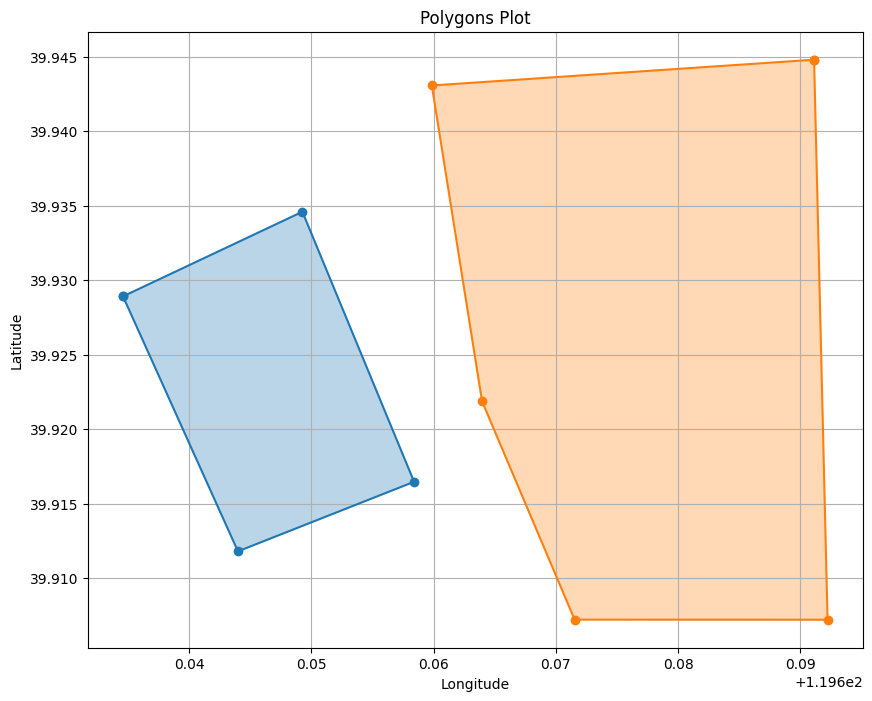

In [19]:
qhd_dock_df = dock_df.loc[dock_df['Id'].isin([9, 10])]

# Create a plot
plt.figure(figsize=(10, 8))

for _, row in qhd_dock_df.iterrows():
    wkt_polygon = row['Polygon']
    pattern = re.compile(r'\d+\.\d+\s\d+\.\d+')
    matches = pattern.findall(wkt_polygon)
    coordinates = [[float(coord) for coord in match.split()] for match in matches]
    print(coordinates)
    polygon = np.array(coordinates)  # Convert to numpy array
    plt.plot(polygon[:, 0], polygon[:, 1], marker='o')
    plt.fill(polygon[:, 0], polygon[:, 1], alpha=0.3)  # Fill the polygon with some transparency

# Set plot labels and title
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Polygons Plot')
plt.grid(True)

# Show the plot
plt.show()

In [10]:
# load data from sql server
conn = pymssql.connect(server, user, password, database)

cleaned_coal_sail_query = f"""
SELECT
	t1.mmsi as mmsi,
	t1.Begin_time as begin_time,
	t1.End_time as end_time,
    t1.Begin_lon as begin_lng,
    t1.Begin_lat as begin_lat,
    t1.nowPortName as now_port_name,
	t1.nowDockName as now_dock_name,
	t1.coal_dock_id as now_polygon_id,
	t2.Name as now_polygon_name,
	t2.Province as now_polygon_province,
	t3.ship_type as ship_type
FROM
(SELECT
    mmsi, Begin_time, End_time, Begin_lon, Begin_lat, nowPortName, nowDockName, coal_dock_id
FROM
    sisi.ShoreNet.tab_sailing_log A
WHERE
    coal_dock_id is NOT NULL
    -- and (A.Event_categories != 'record_poly')
) t1
JOIN (
	SELECT
		Id, Name, Province
	FROM
		sisi.ShoreNet.tab_dock_polygon tdp
) t2 ON t1.coal_dock_id = t2.Id
JOIN (
	SELECT
		mmsi, ship_type
	FROM
		sisi.ShoreNet.dim_ships_static dss
) t3 ON t3.mmsi = t1.mmsi
"""

cleaned_sail_query = f"""
SELECT
	t1.mmsi as mmsi,
	t1.Begin_time as begin_time,
	t1.End_time as end_time,
    t1.Begin_lon as begin_lng,
    t1.Begin_lat as begin_lat,
    t1.nowPortName as now_port_name,
	t1.nowDockName as now_dock_name,
	t1.coal_dock_id as now_polygon_id,
	t2.Name as now_polygon_name,
	t2.Province as now_polygon_province,
	t3.ship_type as ship_type
FROM
(SELECT
    mmsi, Begin_time, End_time, Begin_lon, Begin_lat, nowPortName, nowDockName, coal_dock_id
FROM
    sisi.ShoreNet.tab_sailing_log A
) t1
JOIN (
	SELECT
		Id, Name, Province
	FROM
		sisi.ShoreNet.tab_dock_polygon tdp
) t2 ON t1.coal_dock_id = t2.Id
JOIN (
	SELECT
		mmsi, ship_type
	FROM
		sisi.ShoreNet.dim_ships_static dss
) t3 ON t3.mmsi = t1.mmsi
"""

cleaned_coal_sail_df = pd.read_sql(
    sql=cleaned_coal_sail_query, con=conn
)

cleaned_sail_df = pd.read_sql(
    sql=cleaned_sail_query, con=conn
)
conn.close()

# cleaned_coal_sail_df = cleaned_coal_sail_df.loc[~((cleaned_coal_sail_df['now_polygon_name'].str.contains('拓展')) |
#                                                   (cleaned_coal_sail_df['now_polygon_name'].str.contains('船坞')))]

print(f"停泊日志标记比例: {100 * (cleaned_coal_sail_df.shape[0] / cleaned_sail_df.shape[0])} %")

cleaned_coal_sail_df.sort_values(by=['mmsi', 'begin_time'])
print(cleaned_coal_sail_df['mmsi'].nunique())
print(cleaned_coal_sail_df.shape)
cleaned_coal_sail_df.head()

C:\Users\qiu\AppData\Local\Temp\ipykernel_31292\1656482488.py:73: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  cleaned_coal_sail_df = pd.read_sql(
C:\Users\qiu\AppData\Local\Temp\ipykernel_31292\1656482488.py:77: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  cleaned_sail_df = pd.read_sql(


停泊日志标记比例: 100.0 %
6384
(58243, 11)


mmsi  begin_time    end_time   begin_lng  begin_lat now_port_name  \
0  413330690  1690848029  1691114108  119.514000  35.327000        rizhao   
1  413330890  1672531214  1672967279  120.386002  36.054001       qingdao   
2  413330890  1672531214  1673068980  120.386002  36.054001       qingdao   
3  413330890  1685577758  1686959977  120.732002  36.327999          None   
4  413330890  1687046912  1687132760  120.733002  36.328999          None   

  now_dock_name  now_polygon_id now_polygon_name now_polygon_province  \
0      rizhao11              22         日照煤炭1号码头                  山东省   
1            -1              16           青岛客运2号                  山东省   
2            -1              16           青岛客运2号                  山东省   
3          None              31           拓展码头1号                  山东省   
4          None              31           拓展码头1号                  山东省   

   ship_type  
0         33  
1         90  
2         90  
3         90  
4         90

In [58]:
records_list = []

for mmsi, group in cleaned_coal_sail_df.groupby('mmsi'):
    if group.shape[0] <= 1:
        continue
    elif group['now_port_name'].nunique() < 2:
        continue
    
    group.loc[:, 'next_dock_name'] = group['now_dock_name'].shift(-1)
    group.loc[:, 'next_polygon_id'] = group['now_polygon_id'].shift(-1)
    group.loc[:, 'next_polygon_name'] = group['now_polygon_name'].shift(-1)
    group.loc[:, 'next_port_name'] = group['now_port_name'].shift(-1)
    group.loc[:, 'next_dock_arrive_time'] = group['begin_time'].shift(-1)
    group.loc[:, 'next_port_lng'] = group['begin_lng'].shift(-1)
    group.loc[:, 'next_port_lat'] = group['begin_lat'].shift(-1)

    for _, row in group.iterrows():
        if (row['now_polygon_name'] != row['next_polygon_name']) & (row['now_port_name'] != row['next_port_name']):
            if (not row['next_polygon_name'] is None) & (~np.isnan(row['next_dock_arrive_time'])):
                stop_duration = (row['end_time'] - row['begin_time']) / (3600 * 24)
                sail_duration = (row['next_dock_arrive_time'] - row['end_time']) / (3600 * 24)
                if (stop_duration > 0.25) & (stop_duration < 30): 
                    records_list.append([mmsi, row['now_port_name'], row['begin_lng'], row['begin_lat'], 
                                         row['next_port_name'], row['next_port_lng'], row['next_port_lat'],
                                         float(f"{sail_duration:.2f}")])

records_df = pd.DataFrame(records_list, columns=['mmsi', 'depart_port', 'depart_lng', 'depart_lat', 
                                                 'dest_port', 'dest_lng', 'dest_lat', 'sail_duration'])
print(records_df.dtypes)
records_df.to_csv(rf"C:\Users\qiu\OneDrive\文档\SISI\3沿海干散货研究\data\coal_log_data\2023_coal_depart_dest_ports.csv", index=False, encoding='utf-8-sig')
records_df.describe()

mmsi               int64
depart_port       object
depart_lng       float64
depart_lat       float64
dest_port         object
dest_lng         float64
dest_lat         float64
sail_duration    float64
dtype: object


mmsi   depart_lng   depart_lat     dest_lng     dest_lat  \
count  1.922000e+03  1922.000000  1922.000000  1922.000000  1922.000000   
mean   4.169292e+08   118.416234    34.341022   118.286302    34.565936   
std    4.996726e+07     3.252772     6.086223     3.232640     6.135602   
min    1.523450e+08   108.300003    19.101000   108.300003    19.101200   
25%    4.132381e+08   117.878998    29.937525   117.875702    30.856575   
50%    4.133768e+08   119.007053    38.317951   118.993774    38.321999   
75%    4.141500e+08   120.234274    38.980999   119.677597    38.979000   
max    7.890000e+08   122.207298    40.316002   122.209999    40.320000   

       sail_duration  
count    1922.000000  
mean       84.014948  
std        77.469966  
min         0.000000  
25%        21.257500  
50%        60.690000  
75%       124.465000  
max       352.640000

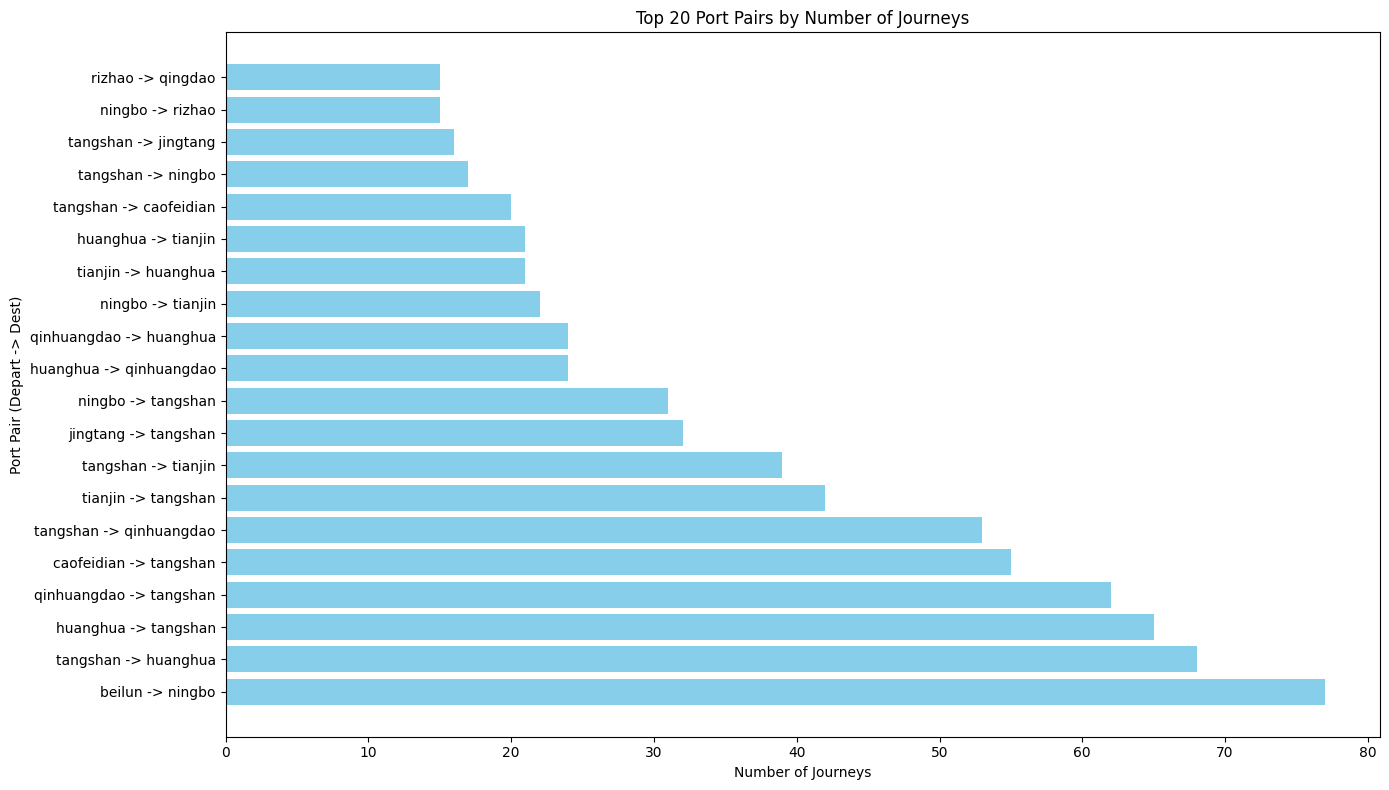

In [120]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
file_path = rf"C:\Users\qiu\OneDrive\文档\SISI\3沿海干散货研究\data\coal_log_data\2023_coal_depart_dest_ports.csv"
df = pd.read_csv(file_path)

# Calculate the top port pairs (depart, dest) count
top_port_pairs = df.groupby(['depart_port', 'dest_port']).size().reset_index(name='count')
top_port_pairs = top_port_pairs.sort_values(by='count', ascending=False).head(20)

# Plotting the top port pairs
plt.figure(figsize=(14, 8))
plt.barh(top_port_pairs.apply(lambda x: f"{x['depart_port']} -> {x['dest_port']}", axis=1), top_port_pairs['count'], color='skyblue')
plt.xlabel('Number of Journeys')
plt.ylabel('Port Pair (Depart -> Dest)')
plt.title('Top 20 Port Pairs by Number of Journeys')
plt.tight_layout()
plt.show()


C:\Users\qiu\AppData\Local\Temp\ipykernel_7116\1179930206.py:16: FutureWarning:

The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.



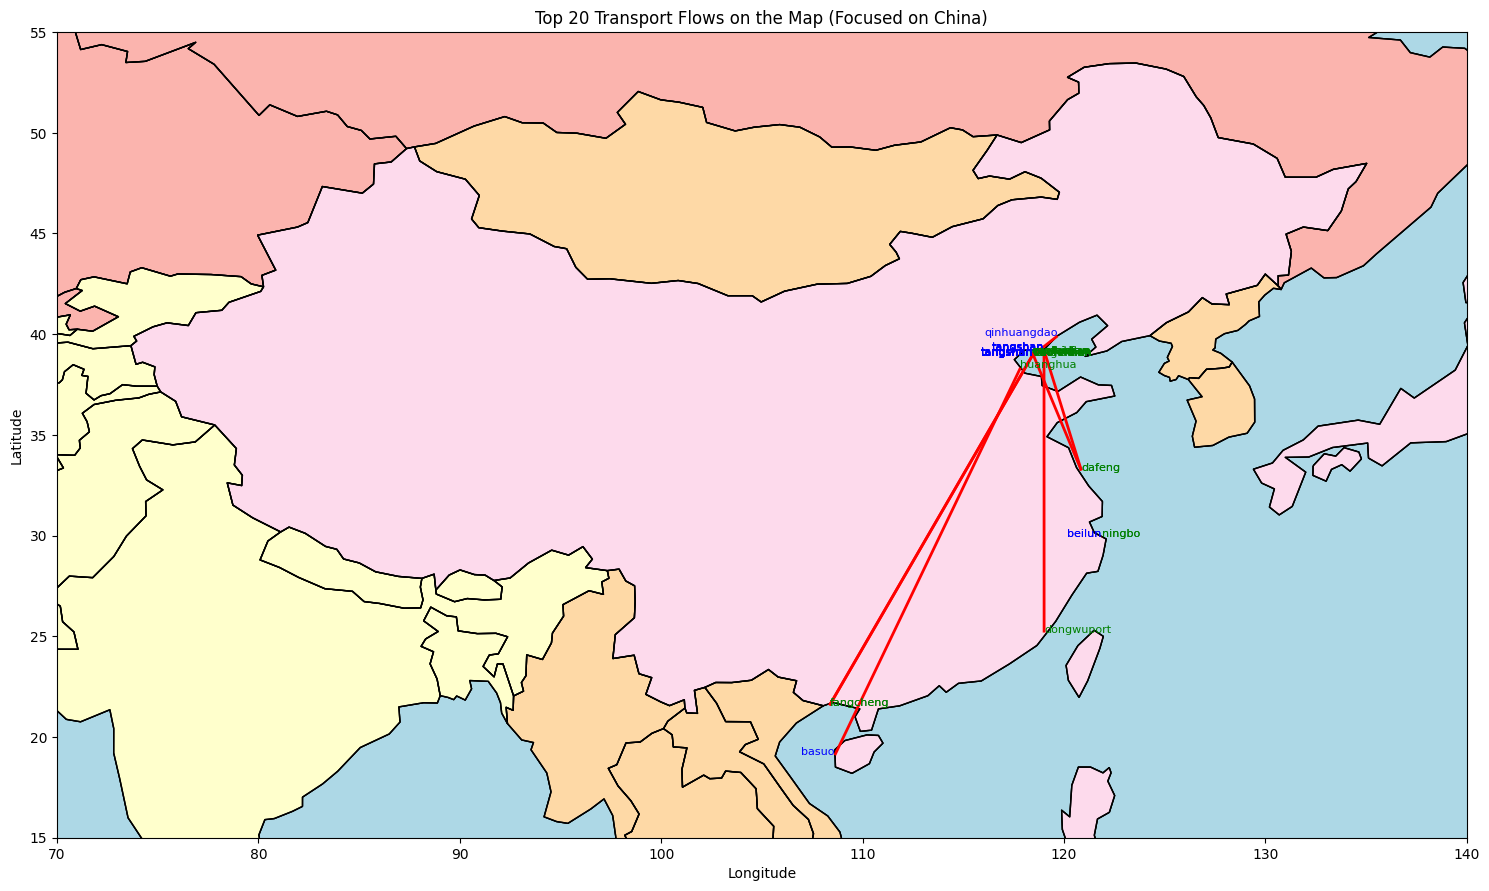

In [118]:
import geopandas as gpd
from shapely.geometry import LineString

# Calculate the top 20 port pairs (depart, dest) count
top_port_pairs = df.groupby(['depart_port', 'dest_port', 'depart_lng', 'depart_lat', 'dest_lng', 'dest_lat']).size().reset_index(name='count')
top_port_pairs = top_port_pairs.sort_values(by='count', ascending=False).head(20)

# Create GeoDataFrame for the top transport flows
lines = []
for idx, row in top_port_pairs.iterrows():
    lines.append(LineString([(row['depart_lng'], row['depart_lat']), (row['dest_lng'], row['dest_lat'])]))

gdf = gpd.GeoDataFrame(top_port_pairs, geometry=lines)

# Plotting the transport flows on the map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

fig, ax = plt.subplots(1, 1, figsize=(15, 10))
world.boundary.plot(ax=ax, linewidth=1, color='black')
world.plot(ax=ax, color='white', edgecolor='black')

# Add ocean and land colors
ax.set_facecolor('lightblue')

# Plotting countries with different colors for better visualization
world.plot(ax=ax, cmap='Pastel1', edgecolor='black')

# Focusing on China
ax.set_xlim([70, 140])
ax.set_ylim([15, 55])

# Plot transport flows with more distinctive color
gdf.plot(ax=ax, color='red', linewidth=2)

# Adding port names to the start and end of the lines
for idx, row in top_port_pairs.iterrows():
    ax.text(row['depart_lng'], row['depart_lat'], row['depart_port'], fontsize=8, ha='right', color='blue')
    ax.text(row['dest_lng'], row['dest_lat'], row['dest_port'], fontsize=8, ha='left', color='green')

plt.title('Top 20 Transport Flows on the Map (Focused on China)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()
plt.show()

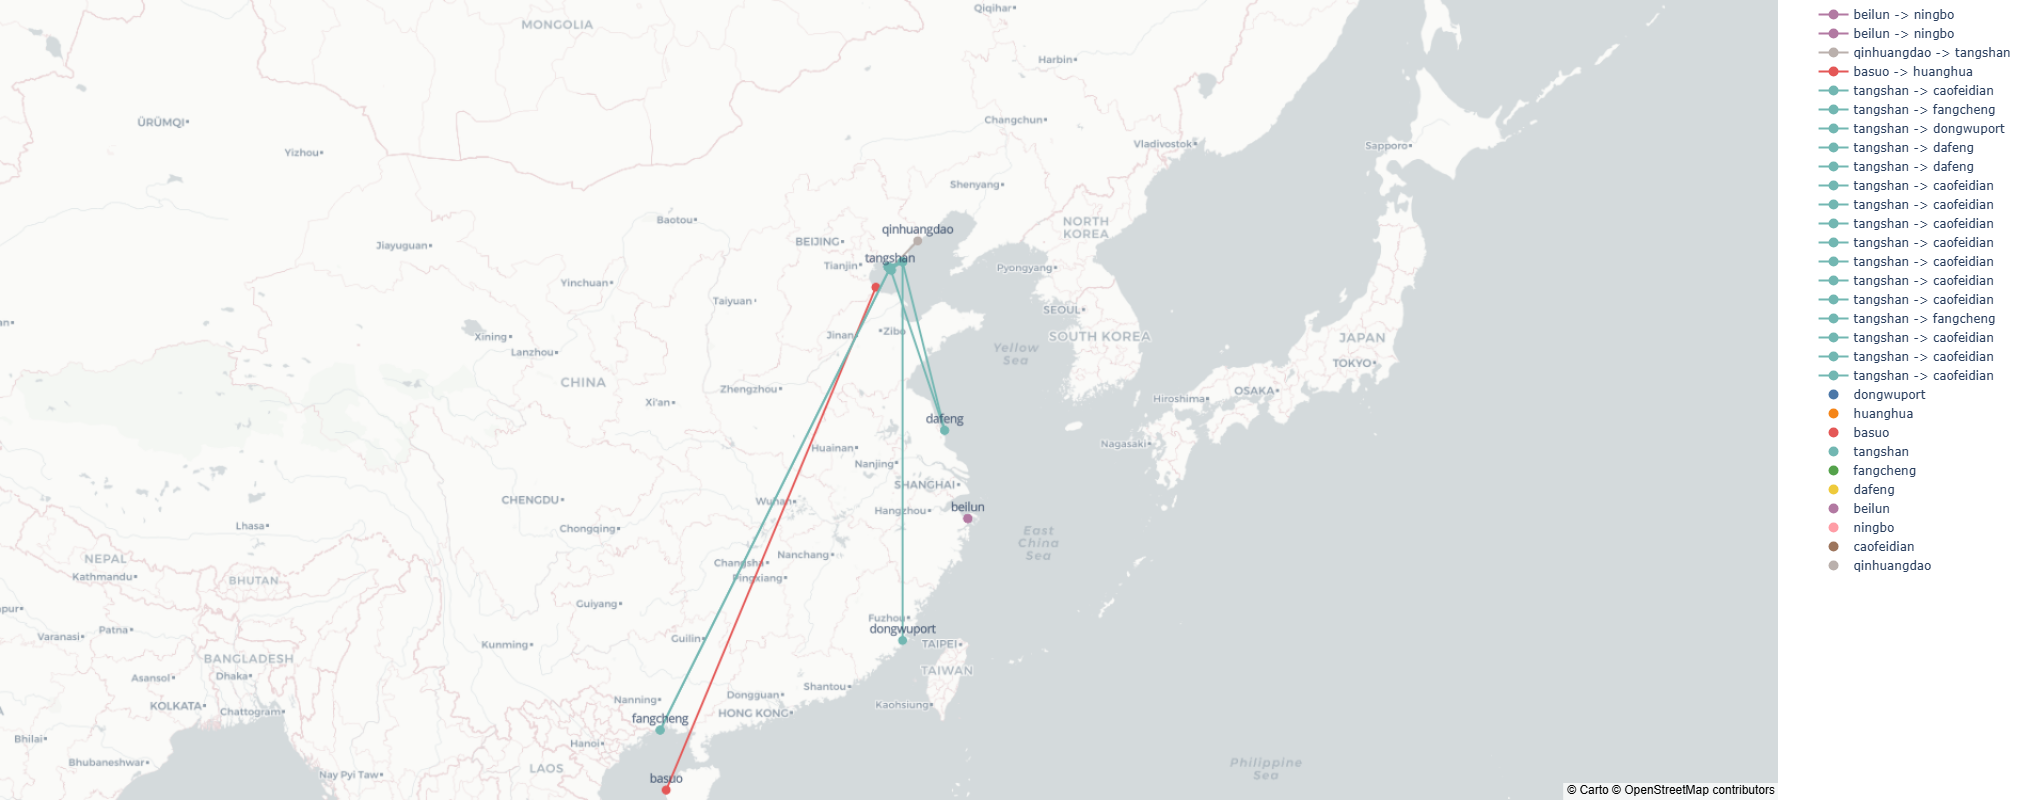

In [119]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

# Calculate the top 20 port pairs (depart, dest) count
top_port_pairs = df.groupby(['depart_port', 'dest_port', 'depart_lng', 'depart_lat', 'dest_lng', 'dest_lat']).size().reset_index(name='count')
top_port_pairs = top_port_pairs.sort_values(by='count', ascending=False).head(20)

# Generate unique colors for each port
ports = list(set(top_port_pairs['depart_port']).union(set(top_port_pairs['dest_port'])))
colors = px.colors.qualitative.T10[:len(ports)]
port_color_map = {port: colors[i] for i, port in enumerate(ports)}

# Create the figure
fig = go.Figure()

# Add transport flows
for idx, row in top_port_pairs.iterrows():
    fig.add_trace(go.Scattermapbox(
        lon=[row['depart_lng'], row['dest_lng']],
        lat=[row['depart_lat'], row['dest_lat']],
        mode='markers+lines+text',
        marker={'size': 10, 'color': port_color_map[row['depart_port']]},
        line=dict(width=2, color=port_color_map[row['depart_port']]),
        text=[row['depart_port'], row['dest_port']],
        textposition='top center',
        name=f"{row['depart_port']} -> {row['dest_port']}"
    ))

# Set the map configuration
fig.update_layout(
    mapbox_style="carto-positron",
    mapbox_center={"lat": df["depart_lat"].mean(), "lon": df["depart_lng"].mean()},
    mapbox=dict(
        zoom=4
    ),
    margin={"r":0,"t":0,"l":0,"b":0},
    showlegend=True,
    width=800,
    height=800,
)

# Add legend
for port, color in port_color_map.items():
    fig.add_trace(go.Scattermapbox(
        lon=[None],
        lat=[None],
        mode='markers',
        marker={'size': 10, 'color': color},
        name=port
    ))

# Show the plot
fig.show()

count    1922.000000
mean       84.014948
std        77.469966
min         0.000000
25%        21.257500
50%        60.690000
75%       124.465000
max       352.640000
Name: sail_duration, dtype: float64


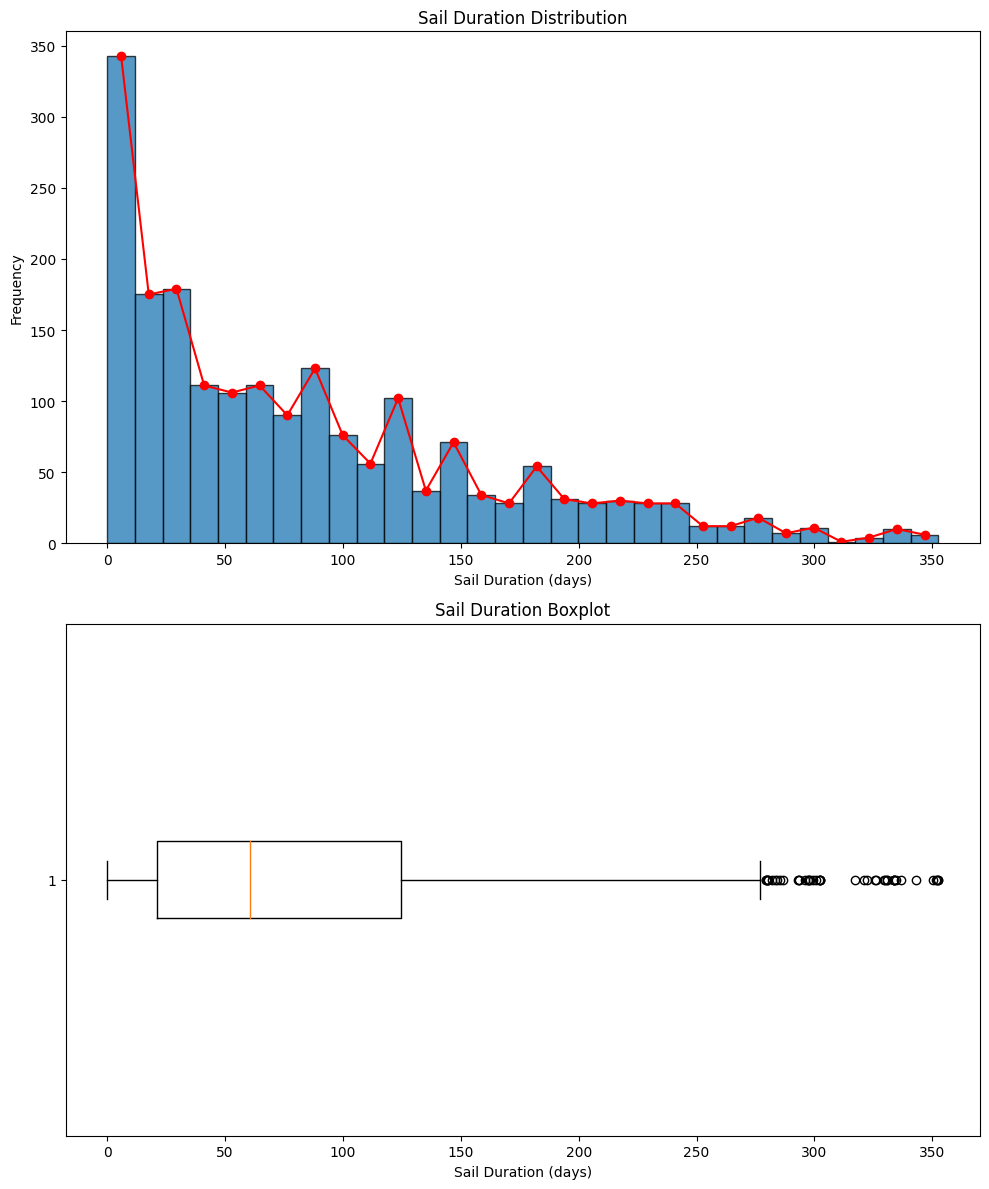

In [122]:
# Plotting Sail Duration Histogram with a Boxplot
fig, ax = plt.subplots(2, 1, figsize=(10, 12))

print(df['sail_duration'].describe())

# Histogram
n, bins, patches = ax[0].hist(df['sail_duration'], bins=30, alpha=0.75, edgecolor='black')
bin_centers = 0.5 * (bins[:-1] + bins[1:])
ax[0].plot(bin_centers, n, '-o', color='red')
ax[0].set_title('Sail Duration Distribution')
ax[0].set_xlabel('Sail Duration (days)')
ax[0].set_ylabel('Frequency')

# Boxplot
ax[1].boxplot(df['sail_duration'], vert=False)
ax[1].set_title('Sail Duration Boxplot')
ax[1].set_xlabel('Sail Duration (days)')

plt.tight_layout()
plt.show()

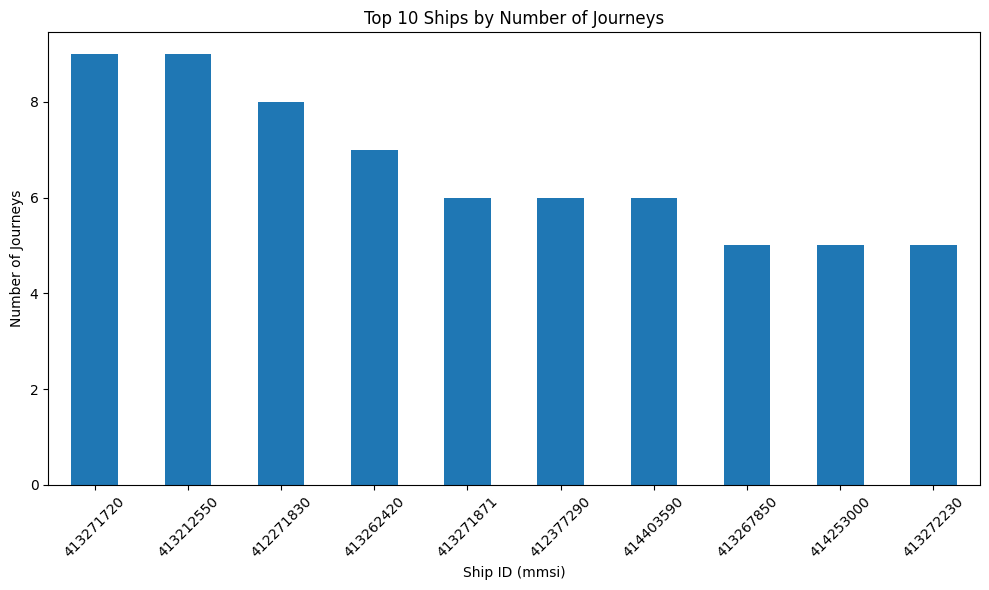

In [50]:
# Journey Counts per Ship
journey_counts_per_ship = df['mmsi'].value_counts()

# Plotting Journey Counts per Ship
plt.figure(figsize=(10, 6))
journey_counts_per_ship.head(10).plot(kind='bar')
plt.title('Top 10 Ships by Number of Journeys')
plt.xlabel('Ship ID (mmsi)')
plt.ylabel('Number of Journeys')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


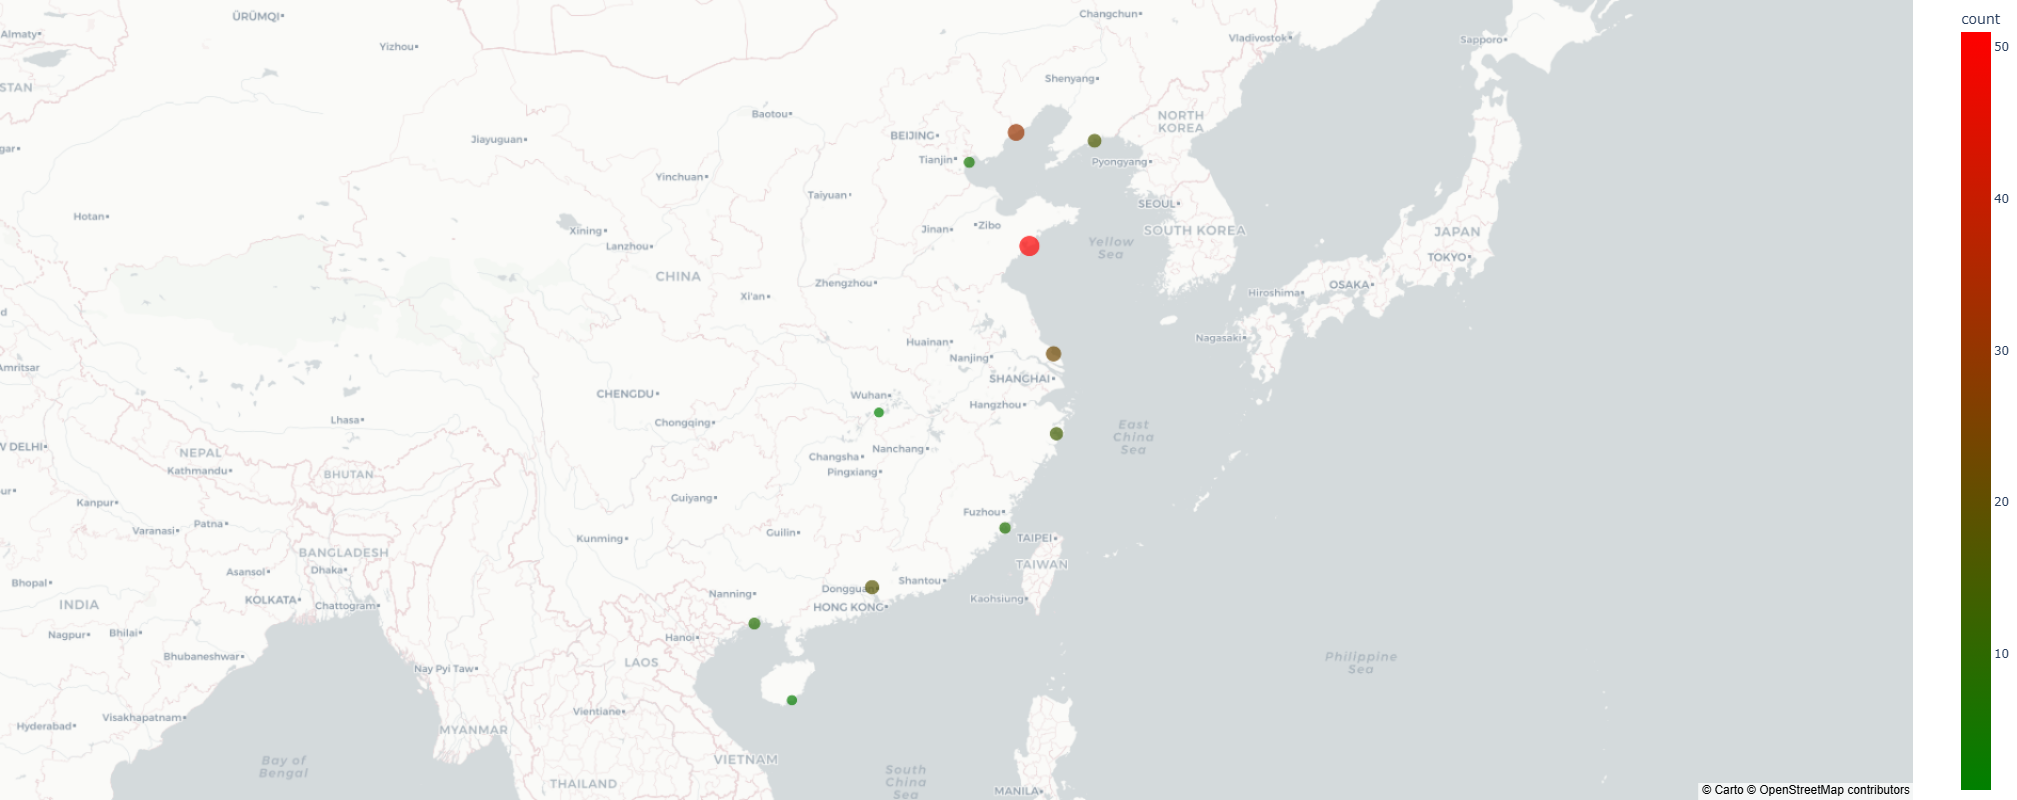

In [99]:
# Load the CSV file
file_path = rf"C:\Users\qiu\OneDrive\文档\SISI\3沿海干散货研究\data\sisi_ShoreNet_tab_dock_polygon.csv"
df = pd.read_csv(file_path)

# Group by District and count the number of occurrences for each district
grouped_df = df.groupby('Province').agg({'lng': 'first', 'lat': 'first', 'Province': 'size'}).rename(columns={'Province': 'count'}).reset_index()

# Normalize sizes to ensure a minimum size of 4
min_marker_size = 4
max_marker_size = 15

# Normalize the counts to the range [min_marker_size, max_marker_size]
grouped_df['size'] = ((grouped_df['count'] - grouped_df['count'].min()) / 
                      (grouped_df['count'].max() - grouped_df['count'].min()) * 
                      (max_marker_size - min_marker_size) + min_marker_size)

# Define custom color scale from purple to red
color_scale = [
    [0, 'green'],
    [1, 'red']
]

# Plot markers on the map with custom color scale and size related to count
fig = px.scatter_mapbox(grouped_df, 
                        lat="lat", 
                        lon="lng", 
                        hover_name="Province", 
                        hover_data=["count"], 
                        color="count",
                        size="size",
                        color_continuous_scale=color_scale,
                        size_max=max_marker_size,
                        zoom=4,
                        mapbox_style="carto-positron")

fig.update_layout(
    mapbox_center={"lat": grouped_df["lat"].mean(), "lon": grouped_df["lng"].mean()},
    margin={"r":0,"t":0,"l":0,"b":0}, width=800,
    height=800,
)

fig.show()

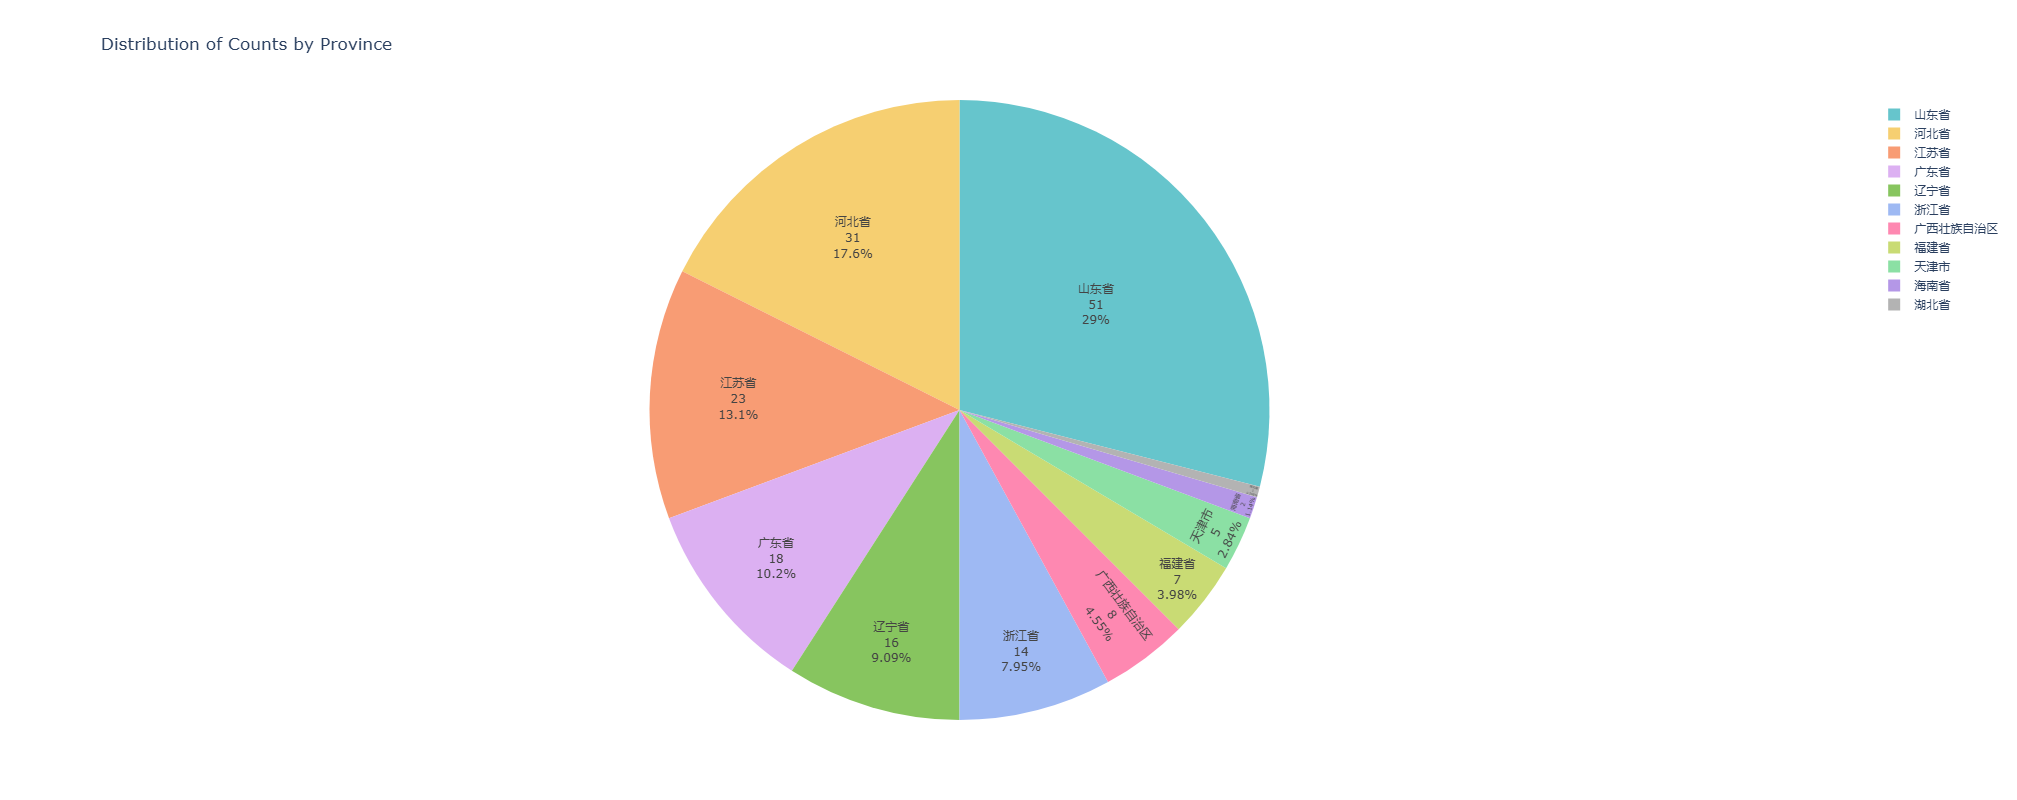

In [103]:
# Group by Province and count the number of occurrences for each province
grouped_province_df = df.groupby('Province').size().reset_index(name='count')

# Plot pie chart
fig = px.pie(grouped_province_df, 
             names='Province', 
             values='count', 
             title='Distribution of Counts by Province',
             color_discrete_sequence=px.colors.qualitative.Pastel,
             hover_data=['count'])

# Add count values on the pie chart
fig.update_traces(textinfo='label+percent+value', textposition='inside')
fig.update_layout( width=800, height=800)

fig.show()

C:\Users\qiu\AppData\Local\Temp\ipykernel_7116\3856992392.py:12: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



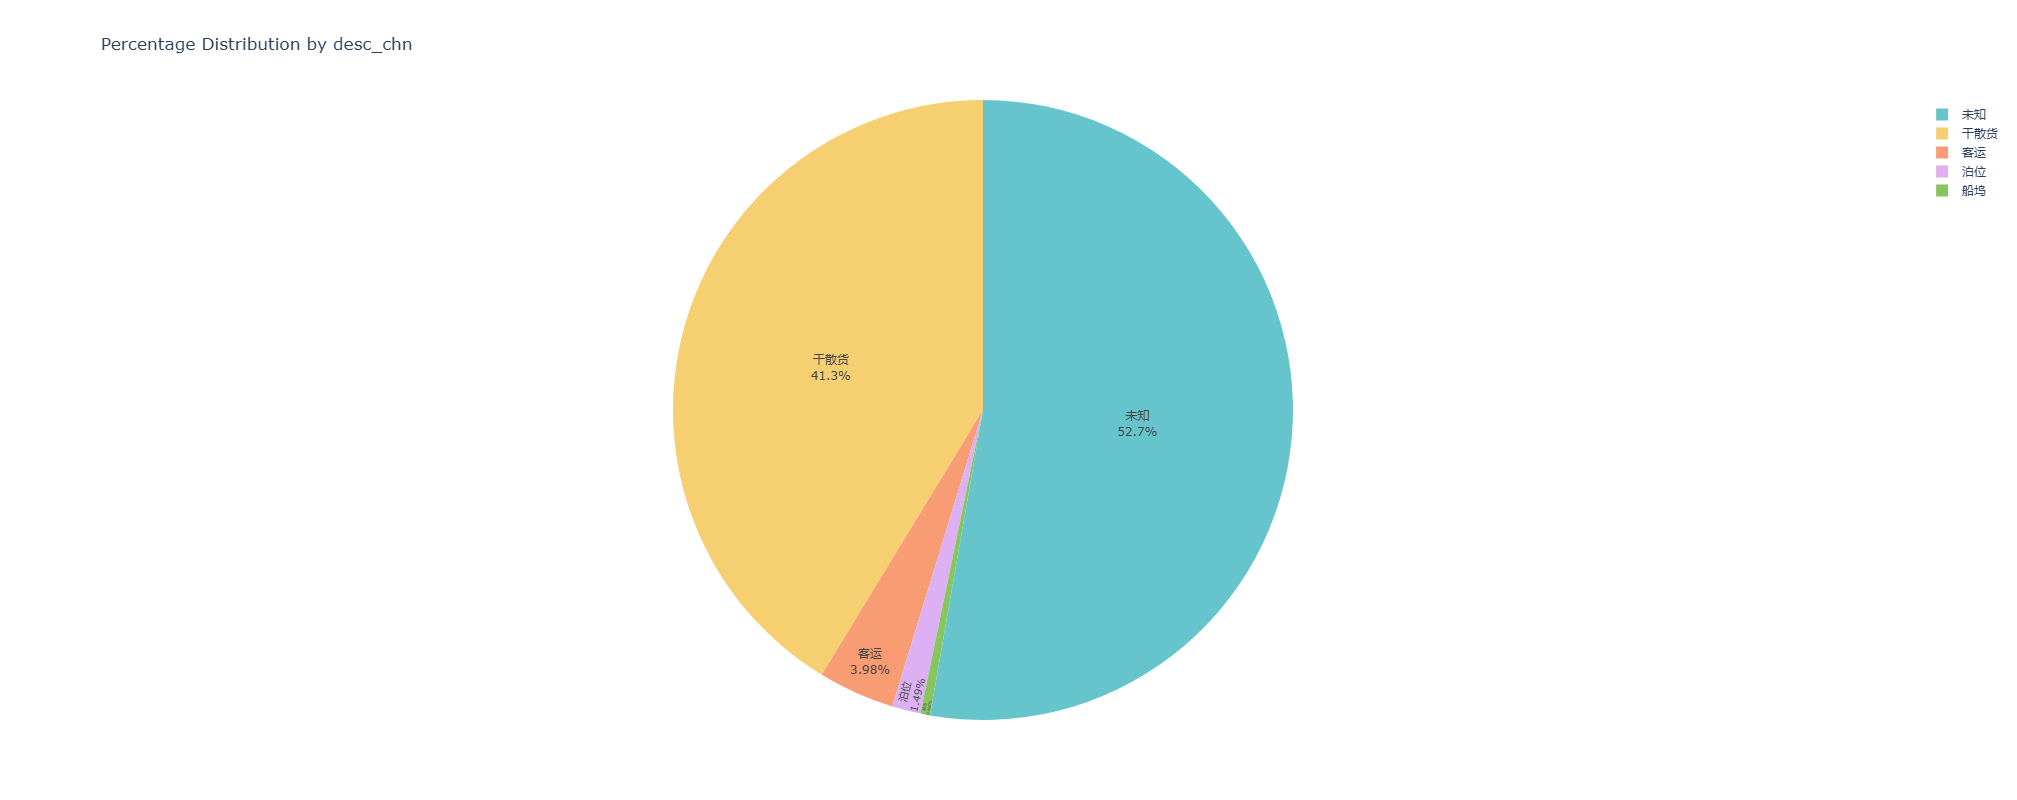

In [115]:
# df = pd.read_csv(rf"C:\Users\qiu\OneDrive\文档\SISI\3沿海干散货研究\data\Result_3.csv")

server = '127.0.0.1'
user = 'sa'
password = 'Amacs@0212'
database = 'sisi'

# Connect to SQL Server
conn = pymssql.connect(server, user, password, database)
cursor = conn.cursor()

df = pd.read_sql(
    sql=f"""
    SELECT
        Name,
        A.type_id as type_id,
        B.polygon_type_sec_chn as desc_chn
    FROM (
        select Name, type_id
        from sisi.ShoreNet.tab_dock_polygon
         ) A join (
             select
                 type_id, polygon_type_sec_chn
             from
                 sisi.ShoreNet.dim_polygon_type
    ) B on A.type_id = B.type_id
    """,
    con=conn
)

# Close the connection
conn.close()

# Group by desc_chn and count the number of occurrences for each value
grouped_desc_df = df.groupby('desc_chn').size().reset_index(name='count')

# Calculate the percentage for each value
grouped_desc_df['percentage'] = (grouped_desc_df['count'] / grouped_desc_df['count'].sum()) * 100
# print(grouped_desc_df)

# Plot pie chart for percentage
fig = px.pie(grouped_desc_df, 
             names='desc_chn', 
             values='percentage', 
             title='Percentage Distribution by desc_chn',
             color_discrete_sequence=px.colors.qualitative.Pastel,
             hover_data=['count', 'percentage'])

# Add percentage values on the pie chart
fig.update_traces(textinfo='label+percent', textposition='inside')

fig.update_layout(width=800, height=800)

fig.show()

# backup

## 3 add dock tag into sailing logs

In [3]:
# find dock
from core.ShoreNet.utils.geo import point_poly, get_geodist
from core.ShoreNet.scripts.parse_kml import parse_kml
from core.ShoreNet.scripts.extensive_dock_dbscan import find_dock

import platform
os_name = platform.system()
if os.name == 'nt' or os_name == 'Windows':
    DATA_PATH = r"D:/data/sisi/"
elif os.name == 'posix' or os_name == 'Linux':
    DATA_PATH = r"/mnt/d/data/sisi/"
else:
    DATA_PATH = "/mnt/d/data/sisi/"

file_name = os.path.join(DATA_PATH, 'dock/docks_stage_2.kml')
dock_polygon_list = parse_kml(file_name)
print(f"dock polygon count: {len(dock_polygon_list)}")

from tqdm.auto import tqdm
tqdm.pandas()

from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)

dock_tag = coal_sail_df.parallel_apply(find_dock, args=(dock_polygon_list, ), axis=1)
coal_sail_df.loc[:, 'coal_dock_name'] = dock_tag
coal_sail_df.head()

dock polygon count: 205
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


C:\Users\qiu\AppData\Local\Temp\ipykernel_384\327529760.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  coal_sail_df.loc[:, 'coal_dock_name'] = dock_tag


mmsi  Begin_time    End_time   Begin_lon  Begin_lat  Point_num  \
194966  100000012  1693588557  1693605576  121.690201  32.142200         12   
194967  100000012  1693613290  1693734166  121.479881  32.129550        117   
194968  100000012  1694127931  1694141846  121.925955  28.555756         14   
194972  100000012  1694320694  1694321426  121.867346  28.718481          2   
194979  100000012  1694606064  1694606689  121.921566  28.829566          2   

        avgSpeed  nowPortName  nowPortId nowDockName nowBerthName  \
194966  0.000000         lusi     3421.0          -1           -1   
194967  0.671072          NaN        NaN         NaN          NaN   
194968  0.800750  taizhouanch     3581.0          -1           -1   
194972  0.000000  taizhouanch     3581.0          -1           -1   
194979  0.929431  taizhouanch     3581.0          -1           -1   

       Event_categories coal_dock_name  
194966  low_speed_event           None  
194967  low_speed_event         拓展码头2号  
194968  low_speed_event           None  
194972  low_speed_event           None  
194979  low_speed_event           None

In [4]:
coal_sail_without_dock_cnt = coal_sail_df.loc[(coal_sail_df['nowPortName'].isna()) & (coal_sail_df['nowDockName'].isna()) & (coal_sail_df['nowBerthName'].isna()) & 
                                              (coal_sail_df['coal_dock_name'].isna())].shape[0]
print(f"The sail events without any polygon counts: {coal_sail_without_dock_cnt}")

print(f"The sail events with dock percentage: {(1 - coal_sail_without_dock_cnt / coal_sail_df.shape[0]) * 100} %")

The sail events without any polygon counts: 8495
The sail events with dock percentage: 89.76777239767773 %


In [6]:
with open('dock_polygon.json', 'w') as f:
    json.dump(dock_polygon_list, f)

- match sail log and dock polygon 1
- analyze dock distribution
- calculate tagging proportion of cargo docks
- calculate 6 features of each dock

In [4]:
# get coal mmsi list
coal_mmsi_list = sail_df.loc[~sail_df['coal_dock_name'].isna()]['mmsi'].values.tolist()
coal_mmsi_list[:5], len(coal_mmsi_list)

# save to json
import json
coal_mmsi_dict = {'mmsi': coal_mmsi_list}

coal_mmsi_file_name = 'coal_mmsi.json'
if os.path.exists(coal_mmsi_file_name):
    print(f"exists coal_mmsi, append mmsi")
    rf = open(coal_mmsi_file_name, 'r')
    exists_mmsi_dict = json.load(rf)
    print(exists_mmsi_dict['mmsi'][:5])
    rf.close()

    coal_mmsi_dict['mmsi'].extend(exists_mmsi_dict['mmsi'])
    coal_mmsi_dict['mmsi'] = list(set(coal_mmsi_dict['mmsi']))
    print(coal_mmsi_dict['mmsi'][:5])

    wf = open(coal_mmsi_file_name, 'w')
    json.dump(coal_mmsi_dict, wf)
    wf.close()
else:
    with open(coal_mmsi_file_name, 'w') as f:
        json.dump(coal_mmsi_dict, wf)

exists coal_mmsi, append mmsi
[696254464, 412352514.0, 411041794, 412352516.0, 411041798]
[696254464, 412352514.0, 411041794, 412352516.0, 229376006]


In [5]:
# get slog without dockname and coal_dock_name
# coal_dock_df = pd.read_csv('/mnt/d/data/sisi/coal_dock_events/202301.csv')
extensive_coal_dock_df = sail_df.loc[(sail_df['coal_dock_name'].isna()) & (sail_df['nowDockName'].isna() & (sail_df['mmsi'].isin(coal_mmsi_dict['mmsi'])))]
extensive_coal_dock_df.to_csv(f"{data_path}/extensive_coal_events/{month}.csv", index=False, encoding='utf-8-sig')
extensive_coal_dock_df.describe()

mmsi    Begin_time      End_time     Begin_lon     Begin_lat  \
count  3.813300e+04  3.813300e+04  3.813300e+04  38133.000000  38133.000000   
mean   4.168160e+08  1.702707e+09  1.702739e+09     97.104514     24.272632   
std    1.316318e+08  8.074639e+05  8.089831e+05     56.853279     18.474230   
min    1.000000e+08  1.701389e+09  1.701389e+09   -179.688496    -53.270881   
25%    3.744280e+08  1.701994e+09  1.702021e+09    109.865600     18.417852   
50%    4.132454e+08  1.702650e+09  1.702698e+09    120.336736     30.103901   
75%    4.433316e+08  1.703451e+09  1.703478e+09    122.457099     35.502050   
max    1.000000e+09  1.704066e+09  1.704067e+09    179.806621     71.660522   

          Point_num      avgSpeed  nowPortId  
count  38133.000000  38133.000000        0.0  
mean      57.506307     15.357311        NaN  
std      237.061696    658.951772        NaN  
min        2.000000      0.000000        NaN  
25%        2.000000      1.153131        NaN  
50%        9.000000      6.785280        NaN  
75%       32.000000     11.287637        NaN  
max    12461.000000  66392.234670        NaN

In [6]:
# coal_sail_df.loc[:, 'event_duration'] = coal_sail_df['End_time'] - coal_sail_df['Begin_time']
# extensive_coal_sail_df = coal_sail_df.loc[(coal_sail_df['nowPortName'].isna() & (coal_sail_df['coal_dock_name'].isna()) & (coal_sail_df['event_duration'] > 1800) & 
#                                           (coal_sail_df['avgSpeed'] < 3))]
# extensive_coal_sail_df.describe()

In [7]:
# import plotly.graph_objects as go

# KEYS = ['中心点经纬度', '维度', '经度', '内容']

# mapbox_access_token = 'pk.eyJ1IjoibWFjc3FpdSIsImEiOiJjbHgxOGdybWQwOTNsMmpxNnR3Y3VpdTdyIn0.FusEYZ-4AUyJfOFVmjQAsw'

# fig = go.Figure(go.Scattermapbox(
#     name='coal extensive records',
#     lat=extensive_coal_sail_df['Begin_lat'],
#     lon=extensive_coal_sail_df['Begin_lon'],
#     mode='markers',
#     showlegend=True,
#     marker=go.scattermapbox.Marker(
#         size=5,
#         color='red',
#         opacity=0.8,
#         symbol='circle'  # 可设置 embassy,marker ,更多在 https://labs.mapbox.com/maki-icons/,
        
#     ),
# ))

# fig.update_layout(
#     autosize=True,
#     hovermode='closest',
#     mapbox=dict(
#         accesstoken=mapbox_access_token,
#         bearing=0,
#         center=go.layout.mapbox.Center(
#             lat=39.926612,
#             lon=119.671715
#         ),
#         pitch=0,
#         zoom=15,
#     )
# )
# # fig.update_layout(mapbox_style="open-street-map", width=800, height=800,)  # satellite
# fig.update_layout(mapbox_style="satellite", width=1200, height=1000,)

# # fig.show()
# fig.write_html(f"./html/{month}_coal_extensive.html")
# # demo
# # https://plotly.com/python/scattermapbox/

In [8]:
# # port coal dock
# port_coal_df = sail_df.loc[(sail_df['coal_dock_name'].isna() & (sail_df['nowDockName'].isna()) & (sail_df['avgSpeed'] < 1))]
# port_coal_df.describe()

In [9]:
# # n = 100
# # chunksize = port_coal_df.shape[0] // n
# # print(f"chunksize = {chunksize}")

# # lat: 28.4, 41.9, lng: 
# port_coal_df = port_coal_df.loc[(port_coal_df['Begin_lat'] > 28.4) & (port_coal_df['Begin_lat'] < 41.9) & 
#                                 (port_coal_df['Begin_lon'] > 105.5) & (port_coal_df['Begin_lon'] < 126)]
# port_coal_df.sort_values(by='Begin_lat', inplace=True, )
# chunksize = port_coal_df.shape[0]
# n = (port_coal_df.shape[0] // chunksize) + 1
# for _, i in enumerate(range(0, port_coal_df.shape[0], chunksize)):
#     _df = port_coal_df.iloc[i:(i + chunksize)]
#     print(_df.shape, i, i+chunksize)
#     fig = go.Figure(go.Scattermapbox(
#         name='port coal records',
#         lat=_df['Begin_lat'],
#         lon=_df['Begin_lon'],
#         mode='markers',
#         showlegend=True,
#         marker=go.scattermapbox.Marker(
#             size=5,
#             color='red',
#             opacity=0.8,
#             symbol='circle'  # 可设置 embassy,marker ,更多在 https://labs.mapbox.com/maki-icons/,
#         ),
#         text=_df['nowPortName']
#     ))
    
#     fig.update_layout(
#         autosize=True,
#         hovermode='closest',
#         mapbox=dict(
#             accesstoken=mapbox_access_token,
#             bearing=0,
#             center=go.layout.mapbox.Center(
#                 lat=39.926612,
#                 lon=119.671715
#             ),
#             pitch=0,
#             zoom=3,
#         )
#     )
#     # fig.update_layout(mapbox_style="open-street-map", width=800, height=800,)  # satellite
#     fig.update_layout(mapbox_style="satellite", width=1200, height=1000,)
    
#     # fig.show()
#     fig.write_html(f"./html/{month}_port_coal_{i//chunksize}_{n}.html")